In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import chromATAC as ca
from chromATAC.integrated import IntData
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [4]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData/'

In [5]:
def Clustered_TEs(chromosome_layer, **kwargs):
    resolution = kwargs.get('resolution')
    conditions = {}
    annotations = {}
    resolution = kwargs.get('resolution')
    ann = {0:'TE with no defined CORTE in any chromosome', 1:'TE with defined CORTEs'}
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in ind.chr.layers[resolution]['TEs']['index'][chr]])
        conditions[chr] = np.array([int(i in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def get_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    resolution=kwargs.get('resolution')
    ann = {i:v for i, v in enumerate(tcga_met[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    mapping = {v:i for i, v in enumerate(tcga_met[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    for chr in ca.info.CHROMOSOMES['numericals'].values():
        samples = chromosome_layer['index'][chr]
        conditions[chr] = [mapping[i.split('_')[0].split('>')[-1]] for i in ind.chr.layers[resolution]['TCGA']['index'][chr]]
        annotations[chr] = ann
    return conditions, annotations
    
def CTeCore_filter(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, chr-1]>=maj]])
        conditions[chr] = np.array([int(i.split('>')[-1] in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def GTeCore_filter(genome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, chr-1]>=maj]])
        conditions[chr] = np.array([int(i.split('>')[-1] in idx) for i in genome_layer['index']])
        annotations[chr] = ann
    return conditions, annotations

def save_correlation(omic, layers, resolution, chr='all', path=".", cmp_method='sim'):
    metrs = ['score', 'pvalue']
    if chr=='all':
        chr=ca.info.CHROMOSOMES['names']
    if not isinstance(chr, list):
        chr = [chr]
    for c in chr:
        path = os.path.join(path, cmp_method+f'/{c}')
        if not os.path.exists(path):
            os.makedirs(path)
        for m in metrs:
            for k, v in omic.layers[resolution]['co'][tuple(sorted(set(layers)))][cmp_method][c][m].items():
                v.to_csv(f'{path}/{c}_{k}_{m}.csv')
def Cnv_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {i:cancer for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    con =  {cancer:i for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    for c in tqdm(range(1, 25)):
        samples = chromosome_layer['index'][c]
        conditions[c] = np.array([con[cnv_meta.iloc[np.where(cnv_meta['name']==sample.split('.bed')[0].split(">")[-1])[0]]['cancer_type'].values.item()] for sample in samples])
        annotations[c] = ann
    return conditions, annotations

import matplotlib.pyplot as plt

def draw_horizontal_lines(regions, multiplier):
    """
    Draw horizontal lines based on a list of start-end tuples.

    Args:
    regions (list of tuples): Each tuple contains (start, end) points of a line.
    multiplier (int or float): Multiplier for determining the vertical position of each line.
    """
    for idx, (start, end) in enumerate(regions):
        vertical_position = idx * multiplier
        plt.hlines(vertical_position, start, end, colors='blue')
        # plt.text(start, vertical_position, f'({start}, {end})')

    plt.xlabel('Position')
    plt.ylabel('Line Index')
    plt.title('Horizontal Lines from Regions')
    plt.grid(True)
    plt.show()

In [6]:
def cnv_gain(matrix):
    m = matrix.copy()
    m[m<=2]=0
    m[m!=0]=1
    return m
def cnv_loss(matrix):
    m = matrix.copy()
    m[m>=2]=0
    m[m!=0]=1
    return m

In [7]:
def cote_present(matrix):
    matrix = matrix.copy()
    matrix[matrix>0]=1
    return matrix

### TE and COTEs

In [9]:
ind = IntData()
# ind.add_layer("TCGA_ATAC", input='/cluster/projects/lupiengroup/People/mossi/data/TCGA/ATAC', resolution=resolution)

ind.add_layer("TEs", input=parent_dir+'/data/V2-TEs/non_olap', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.add_layer("CoTEs", input=parent_dir+'/data/V2-TEs/cores1000', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.chr.add_filter('COTE', Clustered_TEs, ['TEs'])

loading files from: /Users/mossishahi/Code/lupien/IntData//data/V2-TEs/non_olap


100%|█████████████████████████████████████████████████████████████████████████████████| 975/975 [00:09<00:00, 102.96it/s]


loading files from: /Users/mossishahi/Code/lupien/IntData//data/V2-TEs/cores1000


100%|████████████████████████████████████████████████████████████████████████████████| 456/456 [00:00<00:00, 1041.71it/s]


In [10]:
def TE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [11]:
def CoTE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [12]:
ind.chr.add_filter('te_family', TE_family, ['TEs'])
ind.chr.add_filter('cote_family', CoTE_family, ['CoTEs'])

In [13]:
ind.add_layer("CNVAR", input=parent_dir+'/data/CNVAR/segments/beds', feature_type='signal', resolutions=[1e06, 1e07],)
cnv_meta = pd.read_csv(parent_dir+"/data/CNVAR/summary.ascatv3TCGA.penalty70.hg38.tsv", sep='\t')
ind.chr.add_filter('Cancertype', Cnv_cancertype, ['CNVAR'])

loading files from: /Users/mossishahi/Code/lupien/IntData//data/CNVAR/segments/beds


100%|████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:26<00:00,  3.59s/it]


In [14]:
cnv_sig = pd.read_csv(parent_dir+'/data/CNVAR/hg38_cna_signatures_.bed', sep='\t', names = ['chr', 'start', 'end', 'sample', 'n_Major', 'n_Minor', 'CN'])

In [15]:
cnvars = {i:{} for i in ca.info.CHROMOSOMES['names']}
for f in tqdm([i for i in cnvar_files if i.endswith('.bed')]):
    df = pd.read_csv(parent_dir+'/data/CNVAR/segments/beds/'+f, sep='\t', header=None)
    for (i, (j, k, z, t)) in df[df.iloc[:, 3]>2].iterrows():
        if (k, z) in cnvars[j]:
            cnvars[j][(k, z)] += [tuple((t, f))]
        else:
            cnvars[j][(k, z)] = []
            cnvars[j][(k, z)] += [tuple((t, f))]
            # cnvars[j][(k, z)] += [tuple((f, t))]

NameError: name 'cnvar_files' is not defined

In [410]:
chrom = 'chr7'
starts = [s for ((s, e), l) in cnvars[chrom].items()]
ends = [e for ((s, e), l) in cnvars[chrom].items()]
start_counts = pd.Series([i for (s, e) in cnvars[chrom].items()]).value_counts()
n_copies = [np.mean([k for (k, s) in l]) for ((j, e), l) in cnvars[chrom].items()]
n_samples = [len(l) for ((s, e), l) in cnvars[chrom].items()]
cnv_lens = np.array([e-s for (e, s) in zip(ends, starts)])

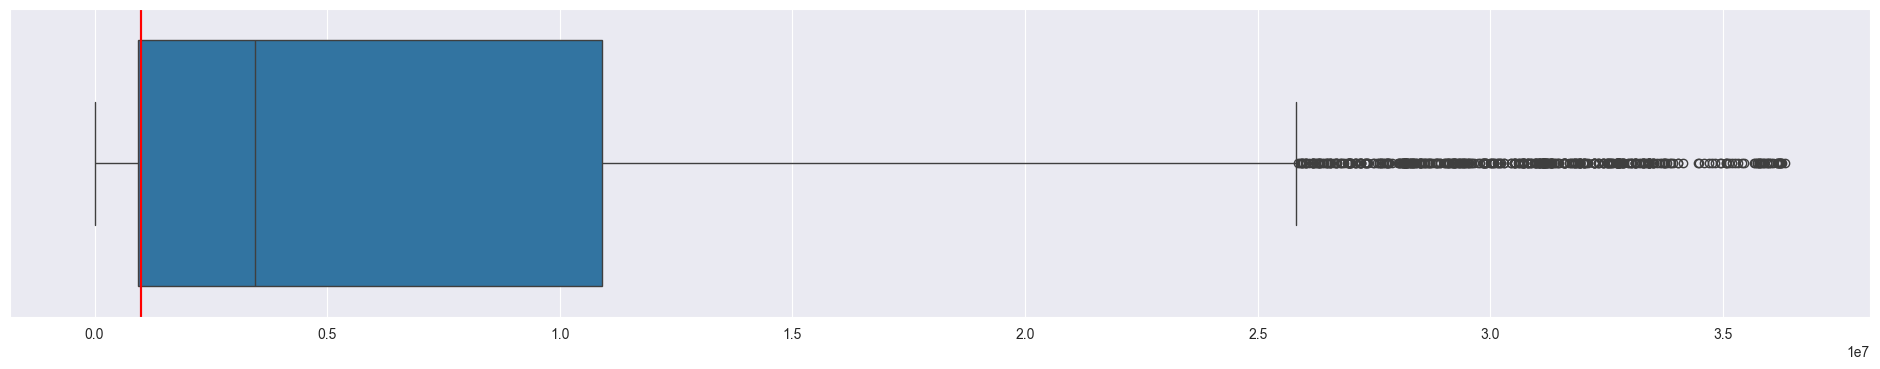

In [382]:
plt.figure(figsize=(24, 4))
sns.boxplot(cnv_lens, orient='h')
plt.axvline(1e06, c='r')
plt.axvline(1e06, c='r')

In [378]:
chrom = 'chr21'
starts = [s for ((s, e), l) in cnvars[chrom].items()]
ends = [e for ((s, e), l) in cnvars[chrom].items()]
start_counts = pd.Series([i for (s, e) in cnvars[chrom].items()]).value_counts()
n_copies = [np.mean([k for (k, s) in l]) for ((j, e), l) in cnvars[chrom].items()]
n_samples = [len(l) for ((s, e), l) in cnvars[chrom].items()]
cnv_lens = np.array([e-s for (e, s) in zip(ends, starts)])

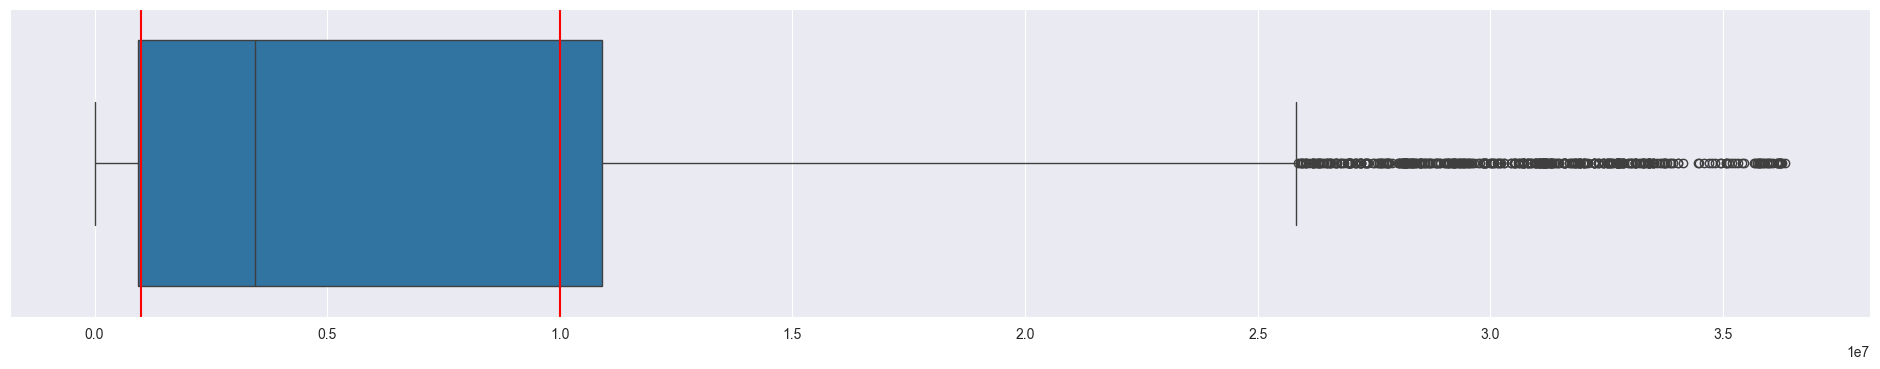

In [381]:
plt.figure(figsize=(24, 4))
sns.boxplot(cnv_lens, orient='h')
plt.axvline(1e06, c='r')
plt.axvline(1e07, c='r')

### CNVAR

In [404]:
ind.add_layer("CNVAR", input=parent_dir+'/data/CNVAR/segments/beds', feature_type='signal', resolutions=[1e06, 1e07],)
cnv_meta = pd.read_csv(parent_dir+"/data/CNVAR/summary.ascatv3TCGA.penalty70.hg38.tsv", sep='\t')
ind.chr.add_filter('Cancertype', Cnv_cancertype, ['CNVAR'])

loading files from: /Users/mossishahi/Code/lupien/IntData//data/CNVAR/segments/beds


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10679/10679 [00:08<00:00, 1216.96it/s]


In [21]:
cnv_sig = pd.read_csv('cnv_sig_reformed.bed', sep='\t')

In [16]:
colors = [
    "navy",
    "grey",
    "gray",
    "paleturquoise",
    "seagreen",
    "navy",
    "orange",
    "olive",
    "crimson",
    "darkorchid",
    "lavender",
    "cyan",
    "yellow",
    "black",
    "violet",
    "silver",
    "blueviolet",
    "slategray",
    "steelblue",
    "plum",
    "indigo"
]
colors = {f'CN{i+1}':v for i, v in enumerate(colors)}

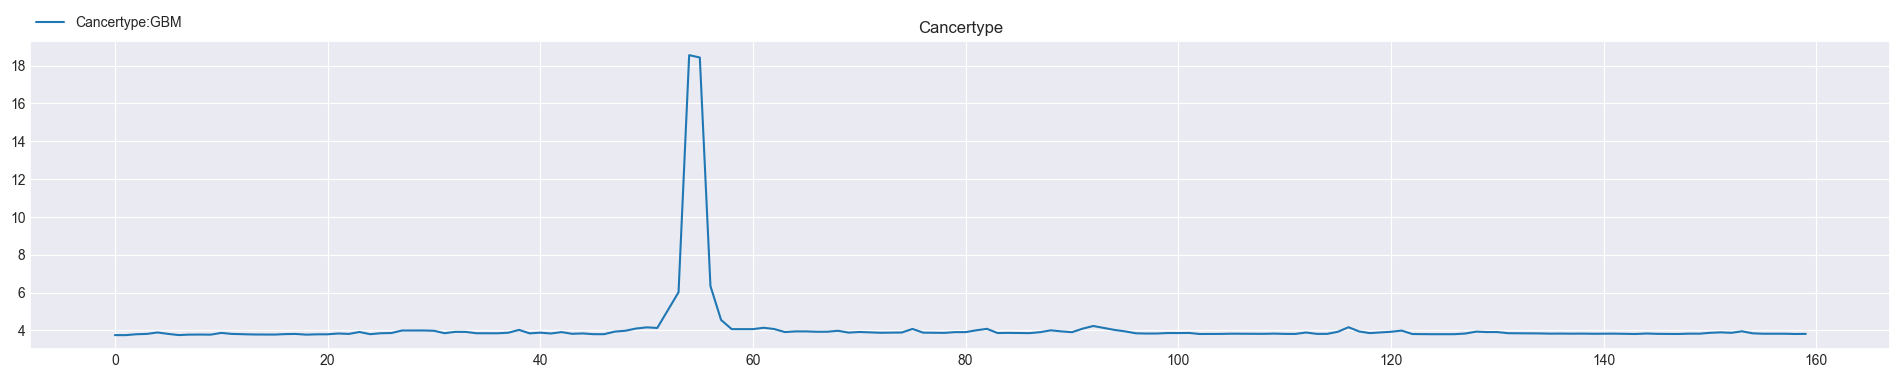

In [28]:
fig=ca.pl.plot_layer(ind.chr, 'CNVAR', chrom='chr7', groups={'Cancertype':'GBM'}, normal_y=False, aggregation='mean')
fig.savefig('gbm_chr7.png')

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerPatch

# Handler for creating legend labels as rectangles
class HandlerRect(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        p = mpatches.Rectangle(xy=(0, 0), width=width, height=height)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def plot_cnv(df, chr='chr7', cancer_type='GBM', colors=colors):
    # Filter the dataframe for the specified chromosome and cancer type
    df = df[df['chr'] == chr]
    ct = df[df['cancer_type'] == cancer_type]
    _ct = df[df['cancer_type'] != cancer_type]

    # Apply ggplot style for demonstration
    plt.style.use('seaborn-v0_8-white')

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Retrieve the default background color and reduce its opacity
    background_opacity = 0.5  # Adjust this value as needed
    default_bg_color = plt.rcParams['axes.facecolor']
    
    # Convert hex to RGBA if necessary
    if isinstance(default_bg_color, str):
        default_bg_color = mcolors.to_rgba(default_bg_color)
    
    new_bg_color = (*default_bg_color[:3], background_opacity)  # Keeping RGB, changing alpha

    for ax in axs:
        ax.set_facecolor(new_bg_color)  # Set the new background color with custom opacity

    # Padding for xlim
    padding_factor = 0.05
    chromosome_length = ca.info.CHROMOSOMES['lens'][chr]
    padding = padding_factor * chromosome_length

    # Plot for cancer type
    axs[0].set_xlim(-padding, chromosome_length + padding)
    axs[0].set_ylim(0, 40)

    for i, row in enumerate(ct.iterrows()):
        axs[0].hlines(row[1]['n_Major'] + row[1]['n_Minor'],
                      int(row[1]['start']),
                      int(row[1]['end']),
                      color=colors[row[1]['CN']],
                     )

    # Plot for non-cancer type
    axs[1].set_xlim(-padding, chromosome_length + padding)
    axs[1].set_ylim(0, 40)

    for i, row in enumerate(_ct.iterrows()):
        axs[1].hlines(row[1]['n_Major'] + row[1]['n_Minor'],
                      int(row[1]['start']), int(row[1]['end']),
                      color=colors[row[1]['CN']],
                     )
    
    # Create legend entries with rectangles
    legend_entries = []
    for cn, color in colors.items():
        rect = mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black')
        legend_entries.append((rect, cn))

    # Create full-figure legend
    fig.legend(handles=[entry[0] for entry in legend_entries], 
               labels=[entry[1] for entry in legend_entries], 
               handler_map={mpatches.Rectangle: HandlerRect()},
               loc='center right', bbox_to_anchor=(1, 0.5))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerPatch
from matplotlib.patches import Arrow


def plot_cnv_sep(df, chr='chr7', 
                 cancer_type='GBM', 
                 colors=colors,
                 major_high=150,
                 minor_high=20,
                 figsize=(12, 10),
                 padding_factor=0.02,
                 spine_color='grey', 
                 spine_opacity=.5,
                 ytick_interval=5,
                 xtick_fontsize=8,
                 legend_title='Signature of Copy Number Alterations in Human Cancer',
                 return_fig=False,
                ):
    df = df[df['chr'] == chr]
    ct = df[df['cancer_type'] == cancer_type]
    _ct = df[df['cancer_type'] != cancer_type]

    plt.style.use('seaborn-v0_8-white')
    fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [major_high//minor_high, 1]})

    # Retrieve the default background color and reduce its opacity
    background_opacity = 0.5  # Adjust this value as needed
    default_bg_color = plt.rcParams['axes.facecolor']
    
    # Convert hex to RGBA if necessary
    if isinstance(default_bg_color, str):
        default_bg_color = mcolors.to_rgba(default_bg_color)
    
    new_bg_color = (*default_bg_color[:3], background_opacity)  # Keeping RGB, changing alpha
    rgba_color = mcolors.to_rgba(spine_color, spine_opacity)  # Convert color to RGBA
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_edgecolor(rgba_color)
        ax.set_facecolor(new_bg_color)  # Set the new background color with custom opacity
    # Padding for xlim
    padding_factor = padding_factor
    chromosome_length = ca.info.CHROMOSOMES['lens'][chr]
    padding = padding_factor * chromosome_length
    
    # Plot n_Major for cancer type on ax[0]
    axs[0].set_xlim(-padding, chromosome_length + padding)
    axs[0].set_ylim(0, major_high)

    for _, row in ct.iterrows():
        axs[0].hlines(row['n_Major'], int(row['start']), int(row['end']),
                      color=colors[row['CN']],
                     )

    # Plot n_Minor for cancer type on ax[1], with mirrored y-axis
    axs[1].invert_yaxis()  # Mirroring the y-axis
    axs[1].set_xlim(-padding, chromosome_length + padding)
    axs[1].set_ylim(minor_high, 0)  # Inverted y-axis

    for _, row in ct.iterrows():
        axs[1].hlines(row['n_Minor'], int(row['start']), int(row['end']),
                      color=colors[row['CN']],
                     )
    legend_entries = []
    for cn, color in colors.items():
        rect = mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='grey')
        legend_entries.append((rect, cn))

    # Create full-figure legend
    legend = fig.legend(handles=[entry[0] for entry in legend_entries], 
               labels=[entry[1] for entry in legend_entries], 
               handler_map={mpatches.Rectangle: HandlerRect()},
               loc='center right', bbox_to_anchor=(.9, 0.5),
              )
    tick_interval = int(1e07)  # 10 Mb interval
    ticks = list(range(0, chromosome_length + 1, tick_interval))
    tick_labels = [f"{int(tick/1_000_000)} Mb" for tick in ticks]

    for i, ax in enumerate(axs):
        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels)
        ax.tick_params(axis='x', labelsize=xtick_fontsize)

        # Determine the maximum y-value for this axis and set y-ticks
        max_y_value = max(ax.get_ylim())
        if i == 0:  # For the upper axis
            y_ticks = list(range(ytick_interval, int(max_y_value) + 1, ytick_interval))
        else:  # For the lower axis (inverted)
            y_ticks = list(range(int(max_y_value) - ytick_interval, 0, -ytick_interval))

        ax.set_yticks(y_ticks)

        
    axs[0].set_ylabel("Major Allele")
    axs[1].set_ylabel("Minor Allele")

    # Set a common ylabel for the entire figure
    fig.text(0.08, 0.4, 'Number of Copies of each Segment', va='center', rotation='vertical', fontsize=16)
    # Optionally, you can set the font size for the legend title
    fig.text(0.9, 0.5, legend_title, ha='left', va='center', rotation=270, fontsize=14)
    fig.suptitle(f'Copy Numbers of Segments of Human Genome, Chromosome: {chr.split('chr')[-1]}, Cancer type: {cancer_type}', fontsize=18)
    plt.subplots_adjust(wspace=0, hspace=0.04, right=0.85, top=0.92)
    plt.show()
    if return_fig:
        return fig

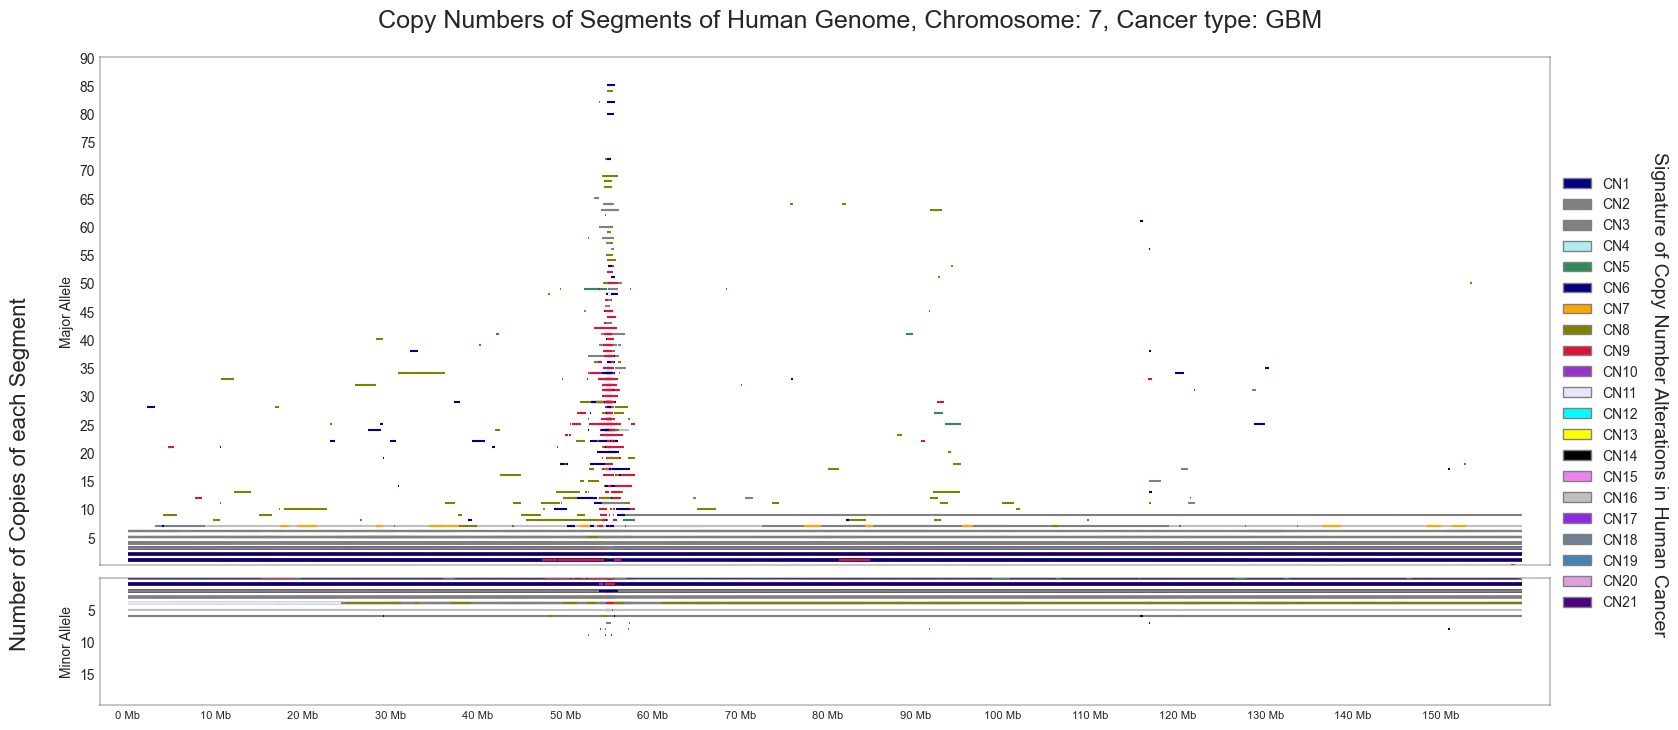

In [22]:
gbm_c7 = plot_cnv_sep(cnv_sig, 'chr7', 'GBM', major_high=90, figsize=(20, 8), return_fig=True)
gbm_c7.savefig('gbm_c7.jpg', bbox_inches='tight')

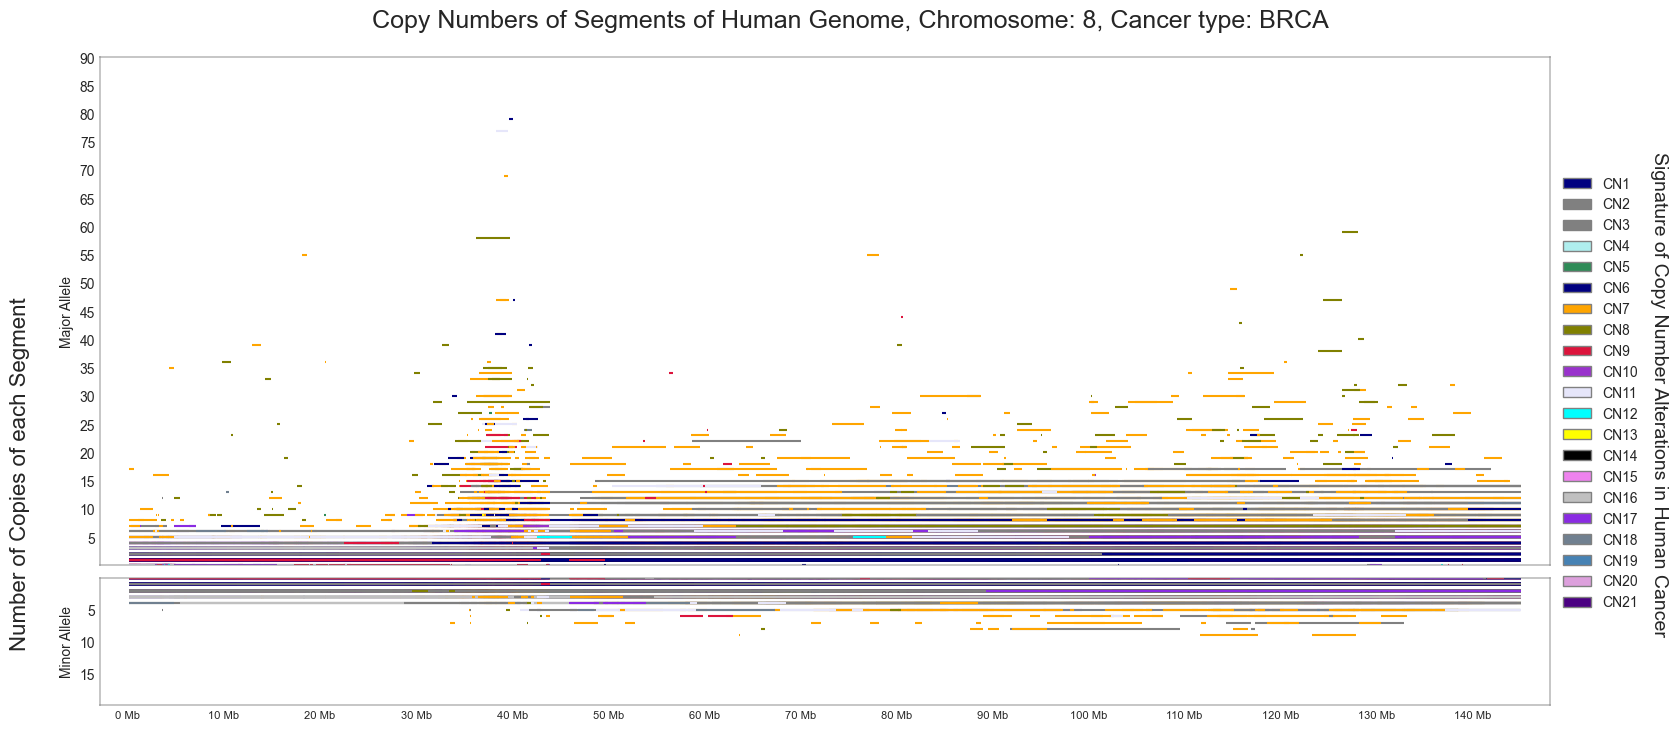

In [23]:
fig = plot_cnv_sep(cnv_sig, 'chr8', 'BRCA', major_high=90, figsize=(20, 8), return_fig=True)
fig.savefig('brca_c8.jpg', bbox_inches='tight', dpi=600)

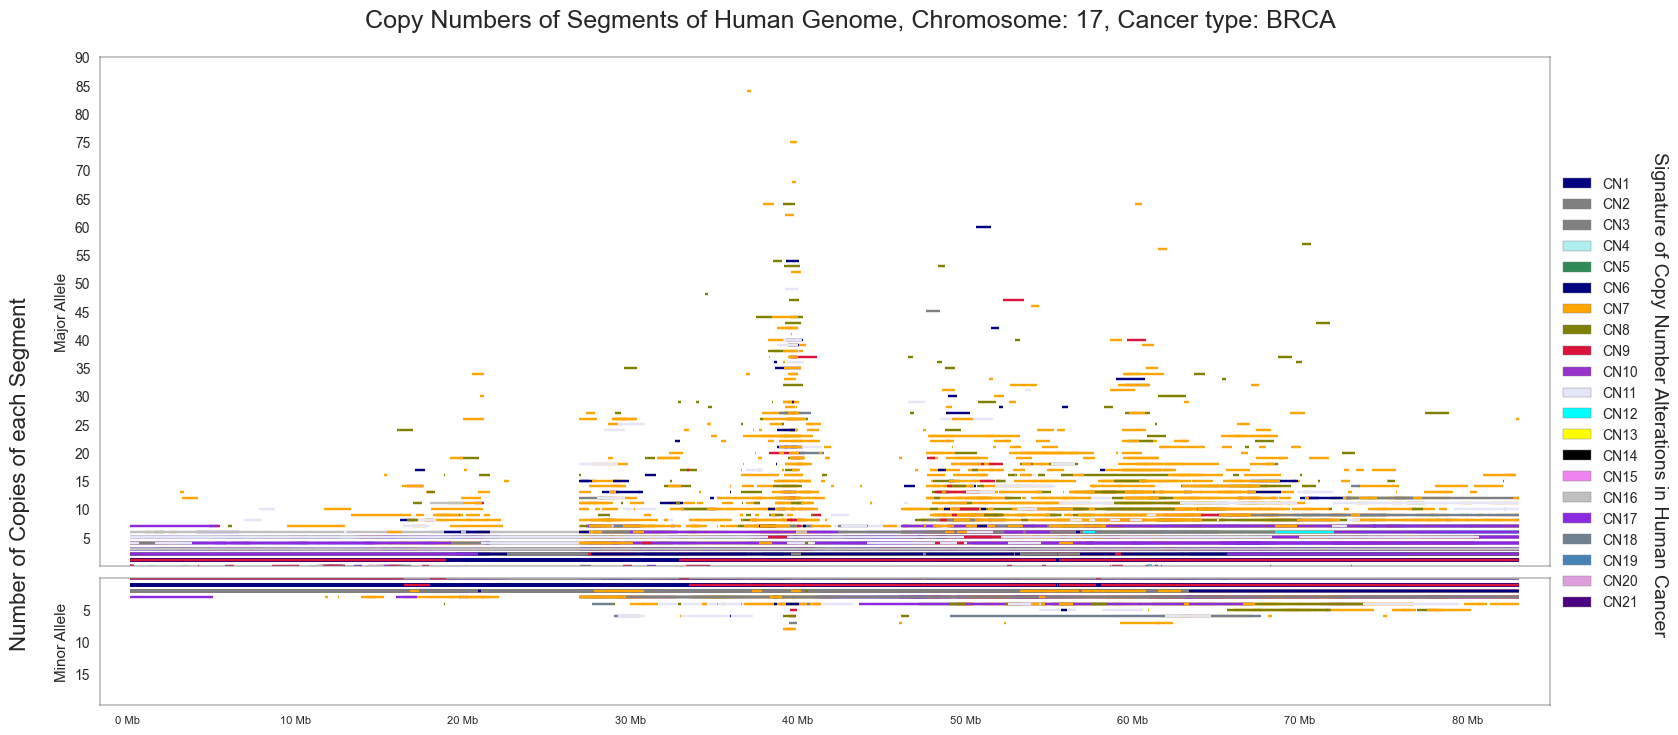

In [502]:
fig = plot_cnv_sep(cnv_sig, 'chr17', 'BRCA', major_high=90, figsize=(20, 8), return_fig=True)
fig.savefig('brca_c17.jpg', bbox_inches='tight', dpi=600)

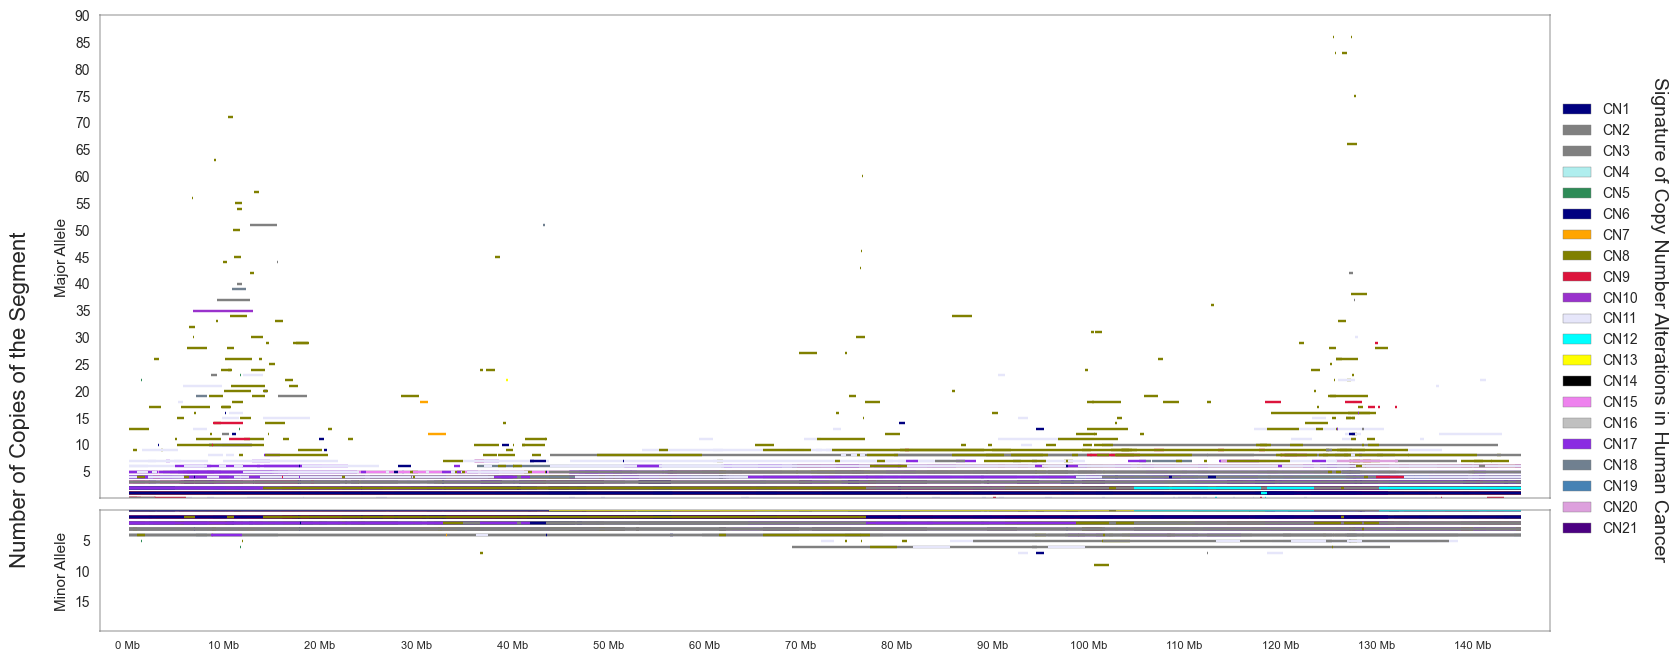

In [469]:
plot_cnv_sep(cnv_sig, 'chr8', 'STAD', major_high=90, figsize=(20, 8))

In [164]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerPatch
from matplotlib.patches import Arrow

def plot_cnv_ct(df, chr='chr7', 
                cancer_type='GBM', 
                allele='major',
                colors=None,
                high_bound=150,
                area_height=1.0,
                line_thickness_scale=1,
                figsize=(12, 10),
                padding_factor=0.02,
                spine_color='grey', 
                spine_opacity=.5,
                ytick_interval=5,
                xtick_fontsize=8,
                legend_title='Signature of Copy Number Alterations in Human Cancer',
                return_fig=False,
                cn_ct_filter=None,
                cn_other_filter=None):
    df = df[df['chr'] == chr]
    ct = df[df['cancer_type'] == cancer_type]
    _ct = df[df['cancer_type'] != cancer_type]

    plt.style.use('seaborn-v0_8-white')
    fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [1, 1]})

    # Retrieve the default background color and reduce its opacity
    background_opacity = 0.5
    default_bg_color = plt.rcParams['axes.facecolor']
    
    if isinstance(default_bg_color, str):
        default_bg_color = mcolors.to_rgba(default_bg_color)
    
    new_bg_color = (*default_bg_color[:3], background_opacity)
    rgba_color = mcolors.to_rgba(spine_color, spine_opacity)
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_edgecolor(rgba_color)
        ax.set_facecolor(new_bg_color)

    padding_factor = padding_factor
    chromosome_length = ca.info.CHROMOSOMES['lens'][chr]
    padding = padding_factor * chromosome_length

    # Define the unique CN values
    unique_cn_values = sorted(set(df['CN']))

    # Ensure the line thickness scale is at least 1
    line_thickness_scale = max(1, line_thickness_scale)

    # Calculate the height each CN line should occupy
    cn_line_height = area_height / len(unique_cn_values) * line_thickness_scale

    # Limit the cn_line_height to the area_height
    cn_line_height = min(cn_line_height, area_height)
    unique_y_bases = sorted(set(df['n_Major'] + df['n_Minor'] if allele == 'all' else df[allele]))
    y_base_offsets = {y_base: i * area_height for i, y_base in enumerate(unique_y_bases)}

    # Plotting logic
    for ax, data in zip(axs, [ct, _ct]):
        for _, row in data.iterrows():
            y_base = row['n_Major'] if allele == 'major' else row['n_Minor']
            if allele == 'all':
                y_base = row['n_Major'] + row['n_Minor']

            if not cn_ct_filter or (row['CN'] in cn_ct_filter):
                cn_index = unique_cn_values.index(row['CN'])
                y_adjusted = y_base_offsets[y_base] + (cn_index + 0.5) * cn_line_height

                ax.hlines(y_adjusted, int(row['start']), int(row['end']), color=colors[row['CN']])#, linewidth=min(cn_line_height, chromosome_length/((row['end']-row['start'])+1)))
        
    axs[0].set_ylabel(f'Cancer type {cancer_type}')
    axs[1].set_ylabel("Other Cancer types")
    axs[0].set_ylim(0, high_bound)
    axs[1].invert_yaxis()  # Mirroring the y-axis
    axs[1].set_xlim(-padding, chromosome_length + padding)
    axs[1].set_ylim(high_bound, 0)  # Inverted y-axis

    # Set a common ylabel for the entire figure
    fig.text(0.04, 0.5, 'Number of Copies in each Segment', va='center', rotation='vertical', fontsize=16)
    # Optionally, you can set the font size for the legend title
    fig.text(0.95, 0.5, legend_title, ha='left', va='center', rotation=270, fontsize=14)
    fig.suptitle(f'Copy Numbers of Segments of Human Genome, Chromosome: {chr.split('chr')[-1]}', fontsize=18)
    plt.subplots_adjust(wspace=0, hspace=0.04, right=0.9, top=0.95, left=.08)
    plt.show()
    if return_fig:
        return fig

In [200]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerPatch
from matplotlib.patches import Arrow


def plot_cnv_ct(df, chr='chr7', 
                 cancer_type='GBM', 
                allele='major',
                 colors=colors,
                 high_bound=150,
                 figsize=(12, 10),
                 padding_factor=0.02,
                 spine_color='grey', 
                 spine_opacity=.5,
                 ytick_interval=5,
                 xtick_fontsize=8,
                height_ratio=3,
                 legend_title='Signature of Copy Number Alterations in Human Cancer',
                 return_fig=False,
                cn_filter=None
               ):
    df = df[df['chr'] == chr]
    if cn_filter:
        df = df[df['CN'].apply(lambda x: x in cn_filter)]
    ct = df[df['cancer_type'] == cancer_type]
    _ct = df[df['cancer_type'] != cancer_type]

    plt.style.use('seaborn-v0_8-white')
    fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [height_ratio, 1]})

    # Retrieve the default background color and reduce its opacity
    background_opacity = 0.5  # Adjust this value as needed
    default_bg_color = plt.rcParams['axes.facecolor']
    
    # Convert hex to RGBA if necessary
    if isinstance(default_bg_color, str):
        default_bg_color = mcolors.to_rgba(default_bg_color)
    
    new_bg_color = (*default_bg_color[:3], background_opacity)  # Keeping RGB, changing alpha
    rgba_color = mcolors.to_rgba(spine_color, spine_opacity)  # Convert color to RGBA
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_edgecolor(rgba_color)
        ax.set_facecolor(new_bg_color)  # Set the new background color with custom opacity
    # Padding for xlim
    padding_factor = padding_factor
    chromosome_length = ca.info.CHROMOSOMES['lens'][chr]
    padding = padding_factor * chromosome_length
    
    # Plot n_Major for cancer type on ax[0]
    axs[0].set_xlim(-padding, chromosome_length + padding)
    axs[0].set_ylim(0, high_bound)
    for _, row in ct.iterrows():
        if allele=='major':
            axs[0].hlines(row['n_Major'], int(row['start']), int(row['end']),
                          color=colors[row['CN']],
                         )
        elif allele=='minor':
            axs[0].hlines(row['n_Minor'], int(row['start']), int(row['end']),
                          color=colors[row['CN']],
                         )
        elif allele=='all':
            axs[0].hlines(row['n_Major']+row['n_Minor'], int(row['start']), int(row['end']),
                          color=colors[row['CN']],
                         )

    # Plot n_Minor for cancer type on ax[1], with mirrored y-axis
    axs[1].invert_yaxis()  # Mirroring the y-axis
    axs[1].set_xlim(-padding, chromosome_length + padding)
    axs[1].set_ylim(high_bound/height_ratio, 0)  # Inverted y-axis

    for _, row in _ct.iterrows():
        if allele=='major':
            axs[1].hlines(row['n_Major'], int(row['start']), int(row['end']),
                          color=colors[row['CN']],
                         )
        elif allele=='minor':
            axs[1].hlines(row['n_Minor'], int(row['start']), int(row['end']),
                          color=colors[row['CN']],
                         )
        elif allele=='all':
            axs[1].hlines(row['n_Major']+row['n_Minor'], int(row['start']), int(row['end']),
                          color=colors[row['CN']],
                             )
    legend_entries = []
    for cn, color in colors.items():
        rect = mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='grey')
        legend_entries.append((rect, cn))

    # Create full-figure legend
    legend = fig.legend(handles=[entry[0] for entry in legend_entries], 
               labels=[entry[1] for entry in legend_entries], 
               handler_map={mpatches.Rectangle: HandlerRect()},
               loc='center right', bbox_to_anchor=(.95, 0.5),
              )
    tick_interval = int(1e07)  # 10 Mb interval
    ticks = list(range(0, chromosome_length + 1, tick_interval))
    tick_labels = [f"{int(tick/1_000_000)} Mb" for tick in ticks]

    for i, ax in enumerate(axs):
        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels)
        ax.tick_params(axis='x', labelsize=xtick_fontsize)

        # Determine the maximum y-value for this axis and set y-ticks
        max_y_value = max(ax.get_ylim())
        if i == 0:  # For the upper axis
            y_ticks = list(range(ytick_interval, int(max_y_value) + 1, ytick_interval))
        else:  # For the lower axis (inverted)
            y_ticks = list(range(int(max_y_value) - ytick_interval, 0, -ytick_interval))

        ax.set_yticks(y_ticks)
        
    axs[0].set_ylabel(f'Cancer type {cancer_type}')
    axs[1].set_ylabel("Other Cancer types")

    # Set a common ylabel for the entire figure
    fig.text(0.04, 0.5, 'Number of Copies in each Segment', va='center', rotation='vertical', fontsize=16)
    # Optionally, you can set the font size for the legend title
    fig.text(0.95, 0.5, legend_title, ha='left', va='center', rotation=270, fontsize=14)
    fig.suptitle(f'Copy Numbers of Segments of Human Genome, Chromosome: {chr.split('chr')[-1]} {cn_filter}', fontsize=18)
    plt.subplots_adjust(wspace=0, hspace=0.04, right=0.9, top=0.95, left=.08)
    plt.show()
    if return_fig:
        return fig


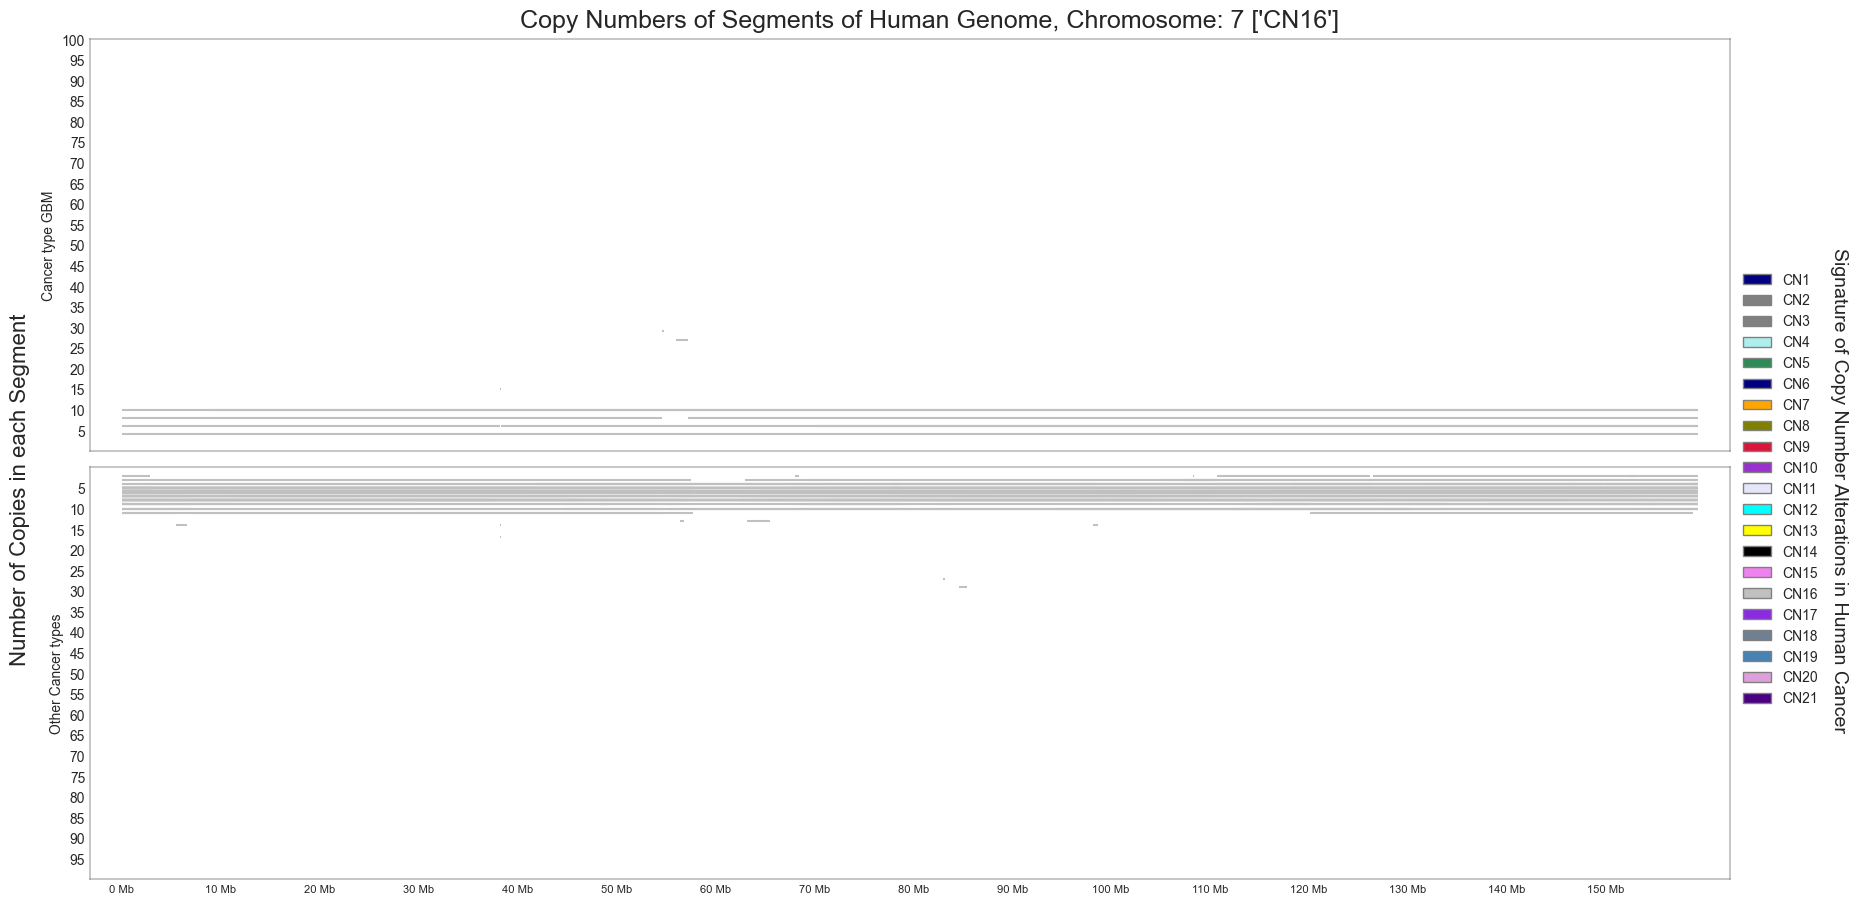

In [209]:
chrom = 'chr7'
ct = 'GBM'
cn_filter = ['CN16']
fig = plot_cnv_ct(cnv_sig, chrom, ct, allele='all', 
                  high_bound=100, 
                  return_fig=True, 
                  figsize=(20, 10), 
                  colors=colors,
                  cn_filter=cn_filter,
                  height_ratio=1
                 )
fig.savefig(f'pcan_{ct}_{chr}_{cn_filter}.jpg', bbox_inches='tight', dpi=600)

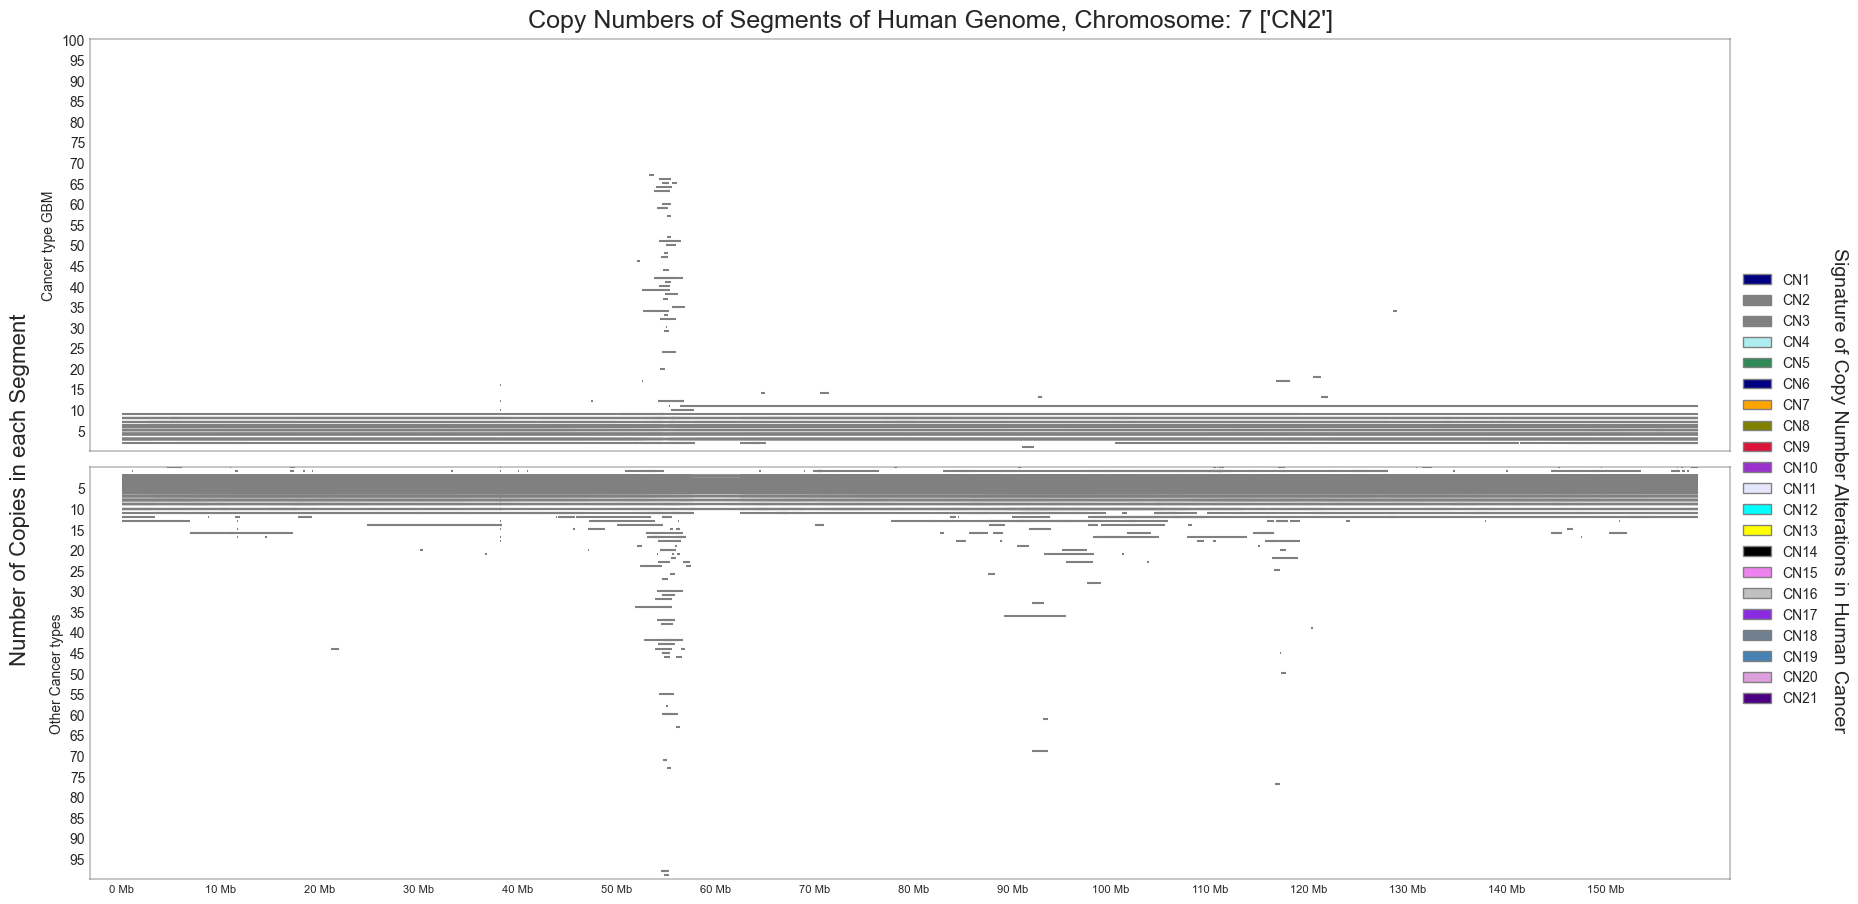

In [208]:
chrom = 'chr7'
ct = 'GBM'
cn_filter = ['CN2']
fig = plot_cnv_ct(cnv_sig, chrom, ct, allele='all', 
                  high_bound=100, 
                  return_fig=True, 
                  figsize=(20, 10), 
                  colors=colors,
                  cn_filter=cn_filter,
                  height_ratio=1
                 )
fig.savefig(f'pcan_{ct}_{chr}_{cn_filter}.jpg', bbox_inches='tight', dpi=600)

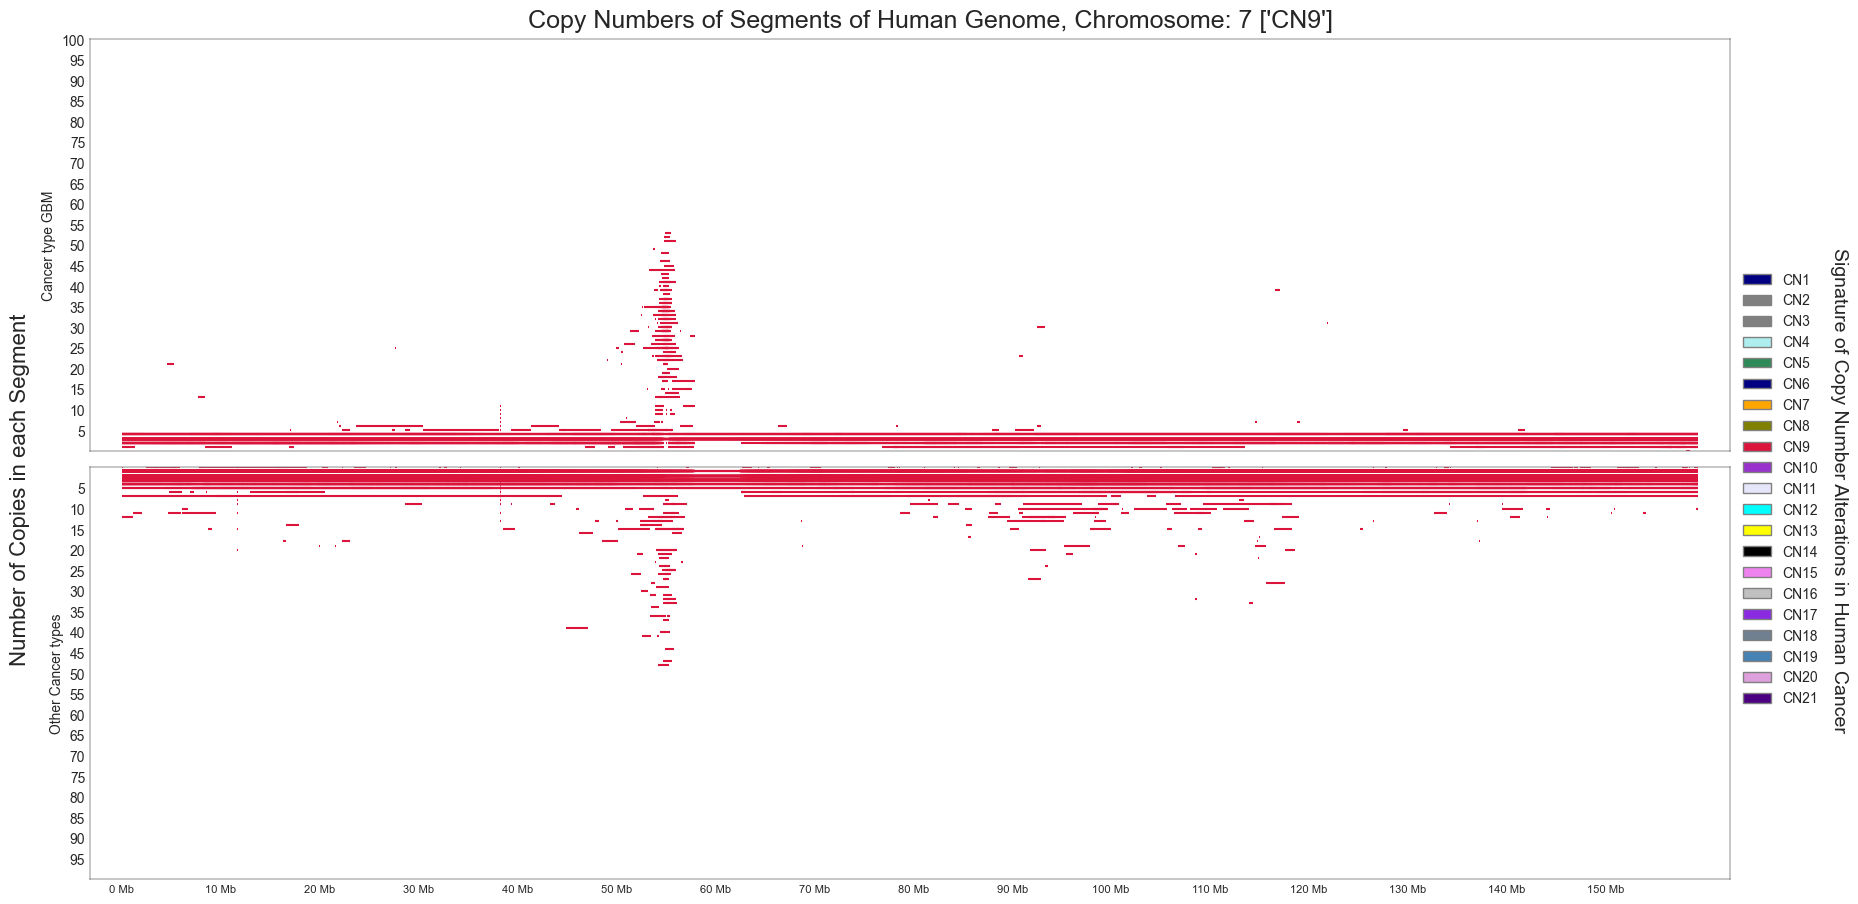

In [212]:
chrom = 'chr7'
ct = 'GBM'
cn_filter = ['CN9']
fig = plot_cnv_ct(cnv_sig, chrom, ct, allele='all', 
                  high_bound=100, 
                  return_fig=True, 
                  figsize=(20, 10), 
                  colors=colors,
                  cn_filter=cn_filter,
                  height_ratio=1
                 )
fig.savefig(f'pcan_{ct}_{chr}_{cn_filter}.jpg', bbox_inches='tight', dpi=600)

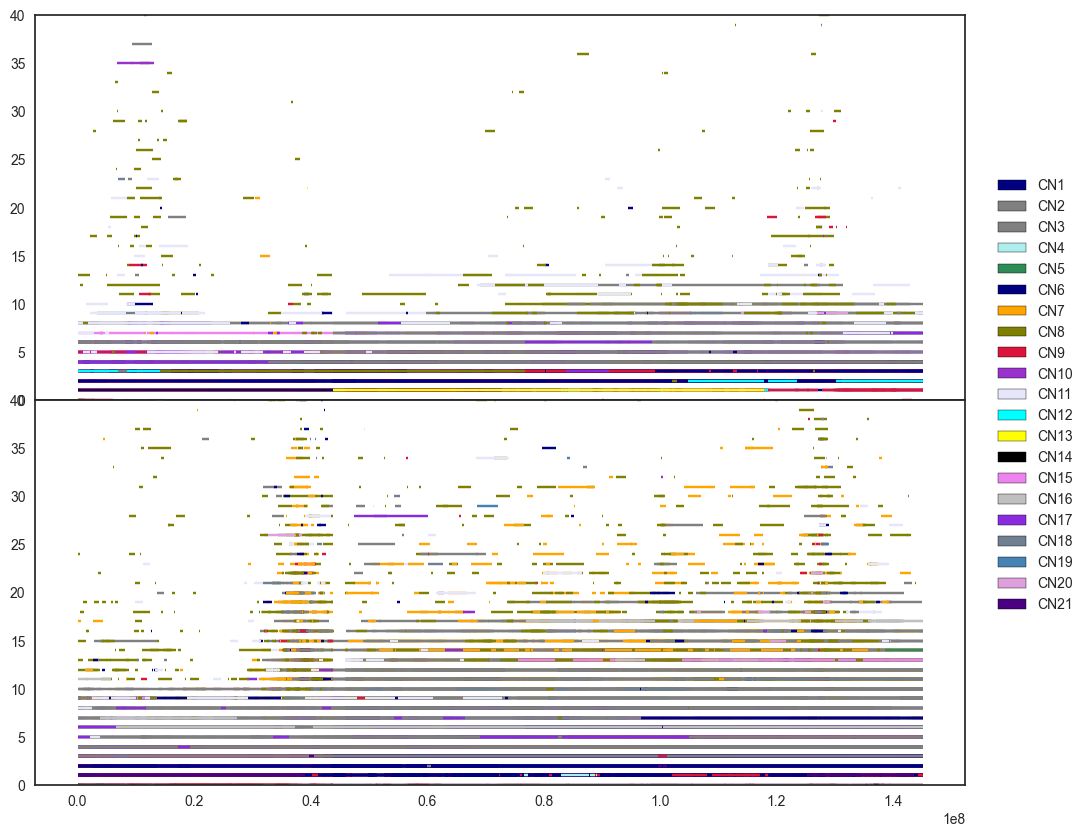

In [322]:
fig = plot_cnv_ct(cnv_sig, 'chr17', 'BRCA', allele='all', high_bound=100, return_fig=True, figsize=(20, 16))
fig.savefig('pcan_brca_c17.jpg', bbox_inches='tight', dpi=600)

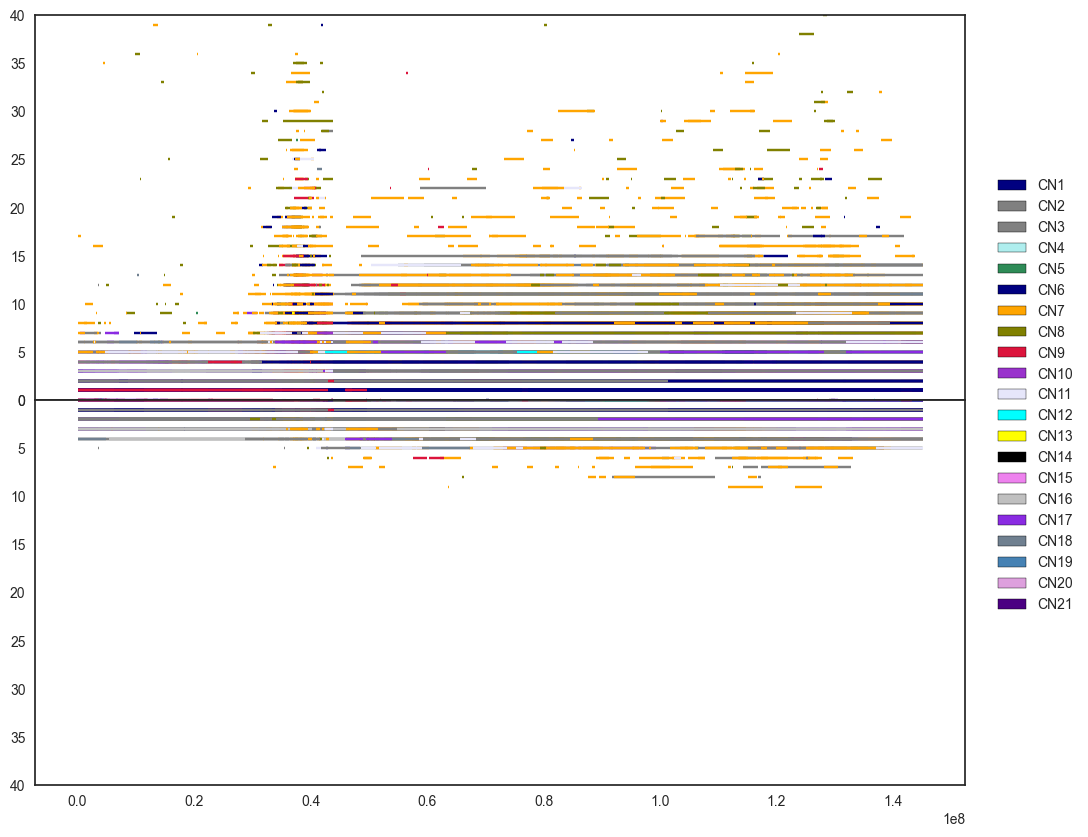

In [337]:
plot_cnv_sep(cnv_sig, 'chr8', 'BRCA')

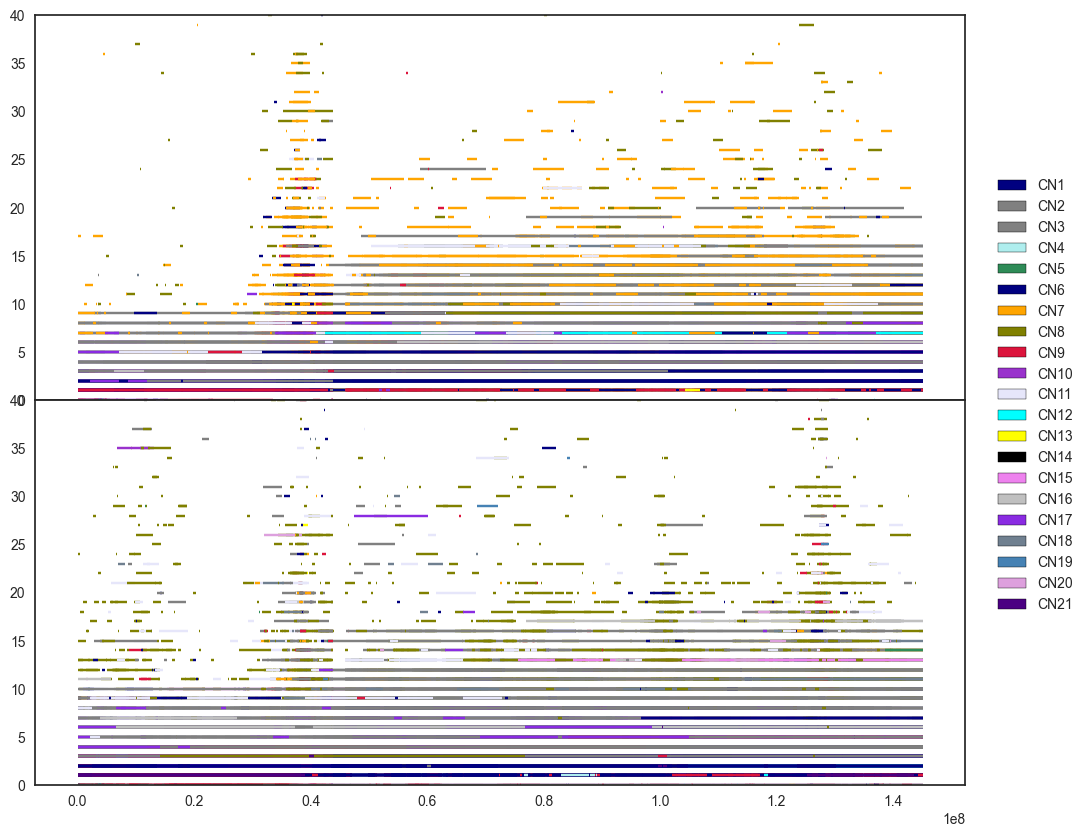

In [336]:
plot_cnv(cnv_sig, 'chr8', 'BRCA')

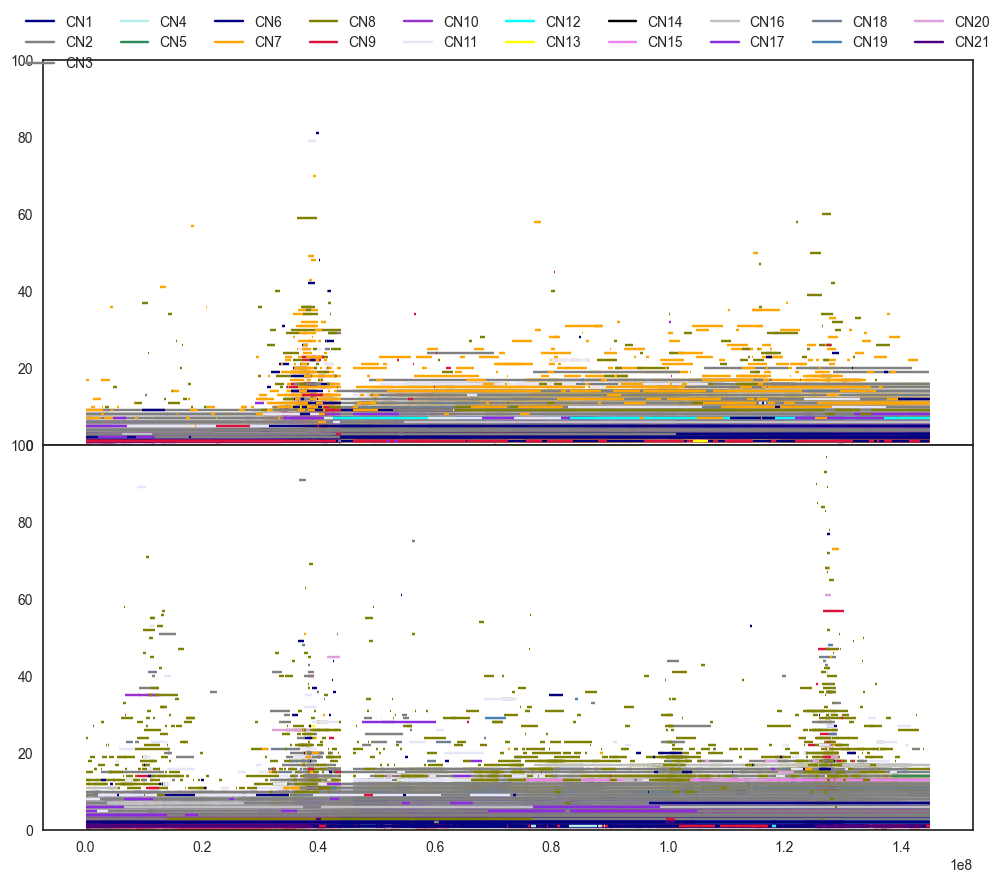

In [290]:
plot_cnv(cnv_sig, 'chr8', 'BRCA')

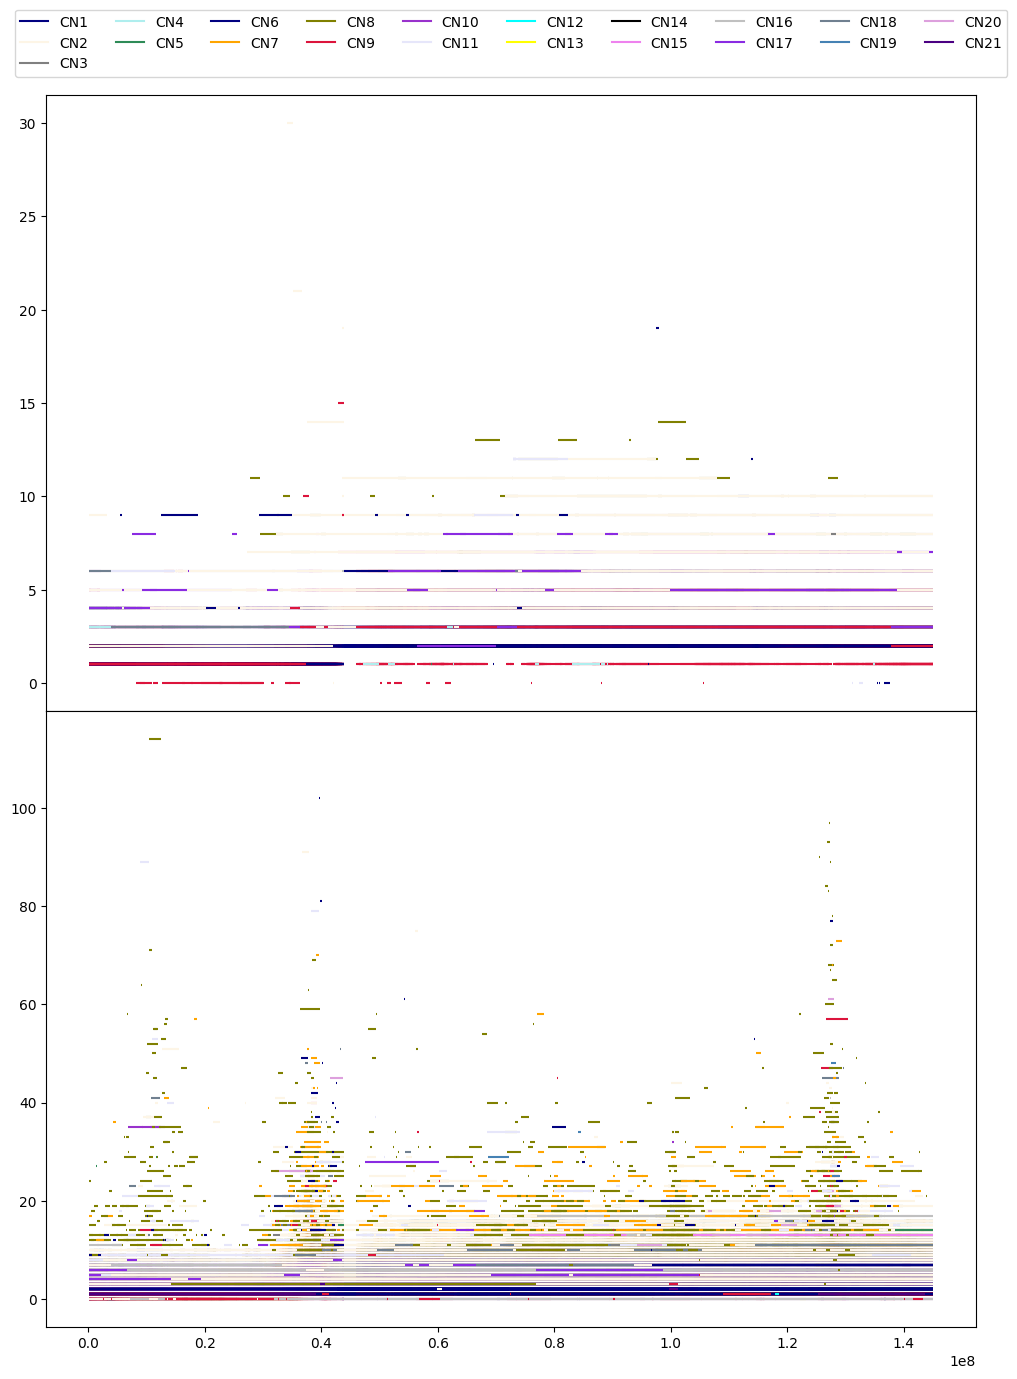

In [202]:
plot_cnv(cnv_sig, 'chr8', 'PRAD')

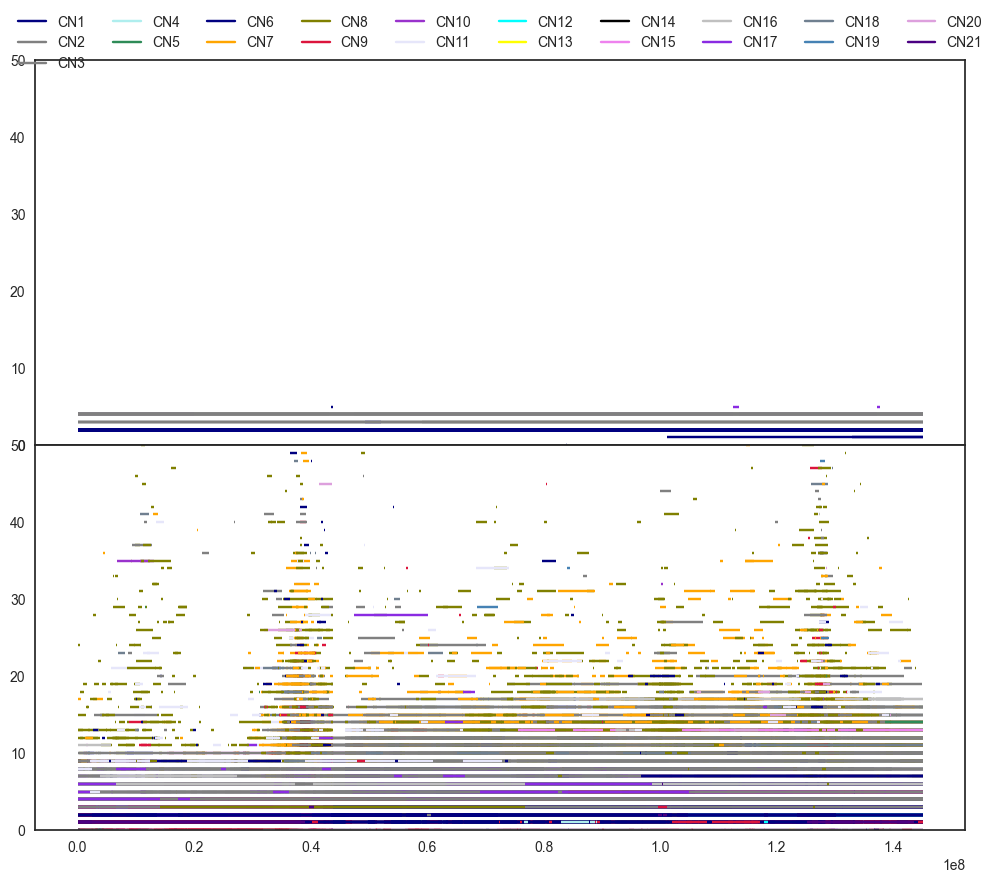

In [271]:
plot_cnv(cnv_sig, 'chr8', 'THCA')

<ul>
    <li><strong>CN1:</strong> Characterized by large (>40 Mb) heterozygous segments with total copy numbers (TCNs) of 2.</li>
    <li><strong>CN2:</strong> Large (>40 Mb) heterozygous segments with TCNs of 3-4.</li>
    <li><strong>CN3:</strong> Heterozygous segments larger than 1 Mb with TCNs between 5 and 8.</li>
    <li><strong>CN4 to CN8:</strong> Each group has segment sizes between 100 kb and 10 Mb, but with varying TCN or LOH states.</li>
    <li><strong>CN9 to CN12:</strong> Feature numerous LOH components with segment sizes under 40 Mb.</li>
    <li><strong>CN13 to CN16:</strong> Characterized by whole-arm-scale or whole-chromosome-scale LOH events (larger than 40 Mb).</li>
    <li><strong>CN17:</strong> Consists of LOH segments with TCNs between 2 and 4, as well as heterozygous segments with TCNs between 3 and 8, each with segment sizes 1–40 Mb.</li>
    <li><strong>CN18 to CN21:</strong> Exhibit complex patterns of copy number alterations that are uncommon but seen in distinct cancer types.</li>
</ul>


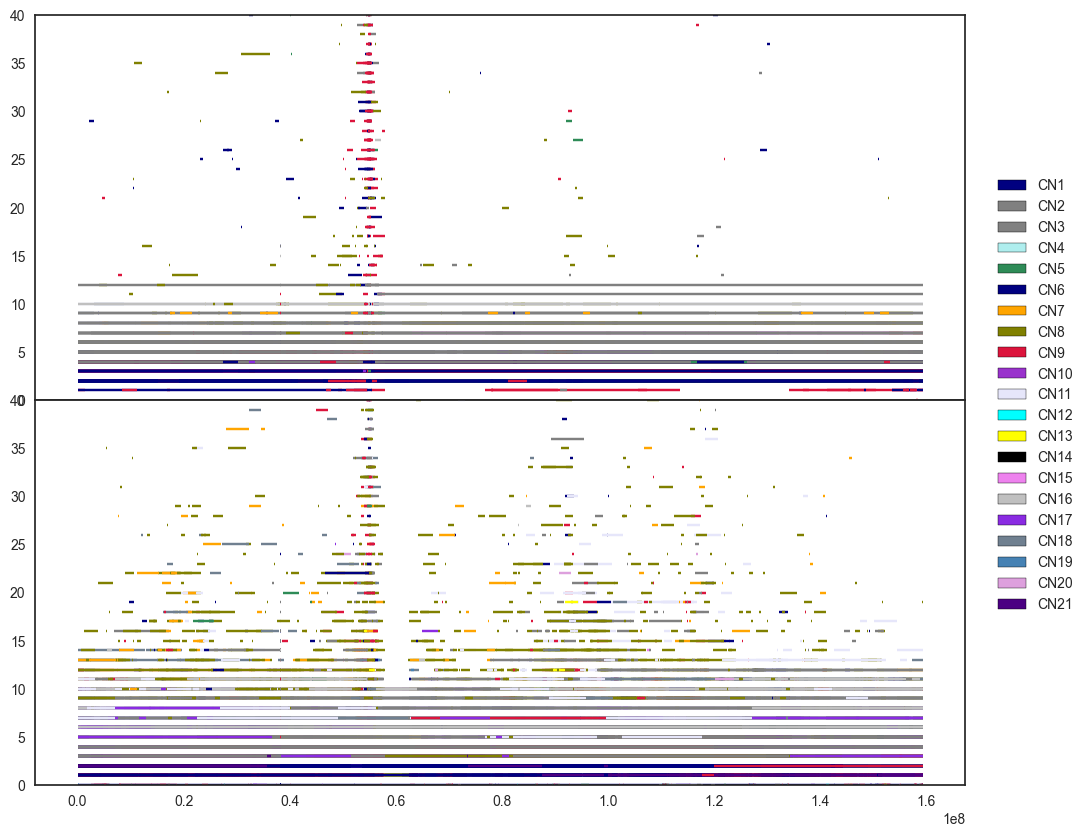

In [323]:
plot_cnv(cnv_sig, 'chr7', 'GBM')

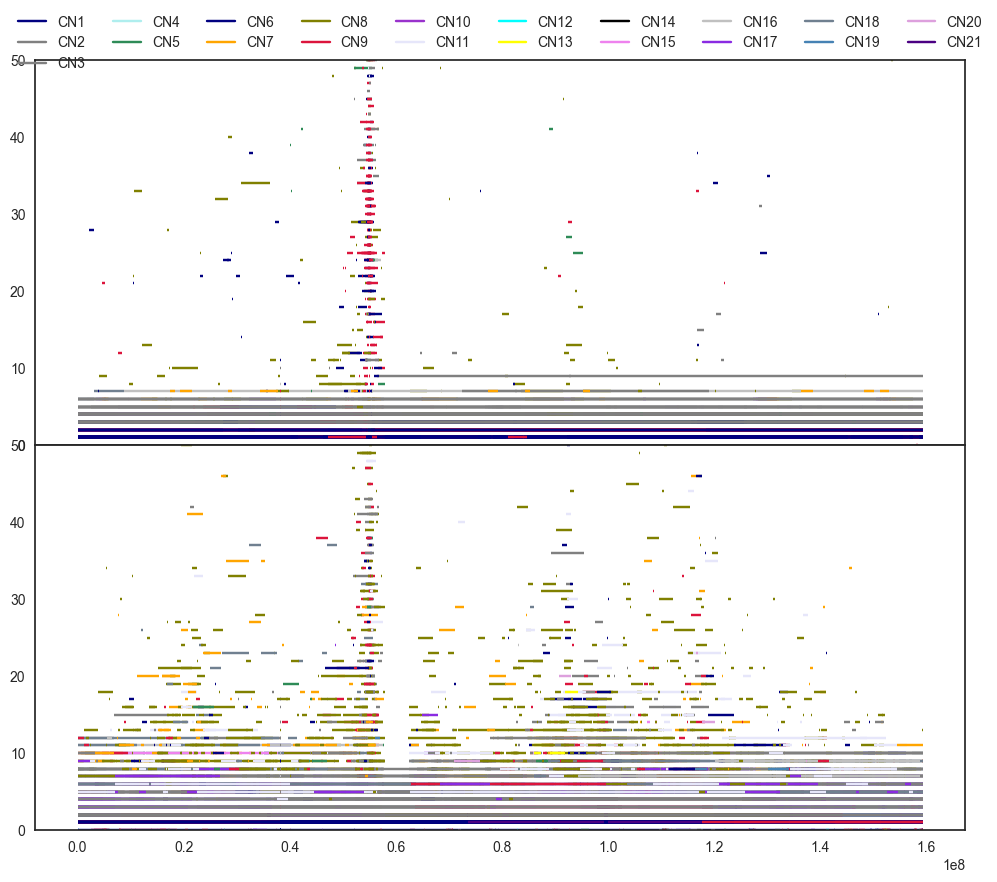

In [285]:
plot_cnv(cnv_sig, 'chr7', 'GBM', al_major=True)

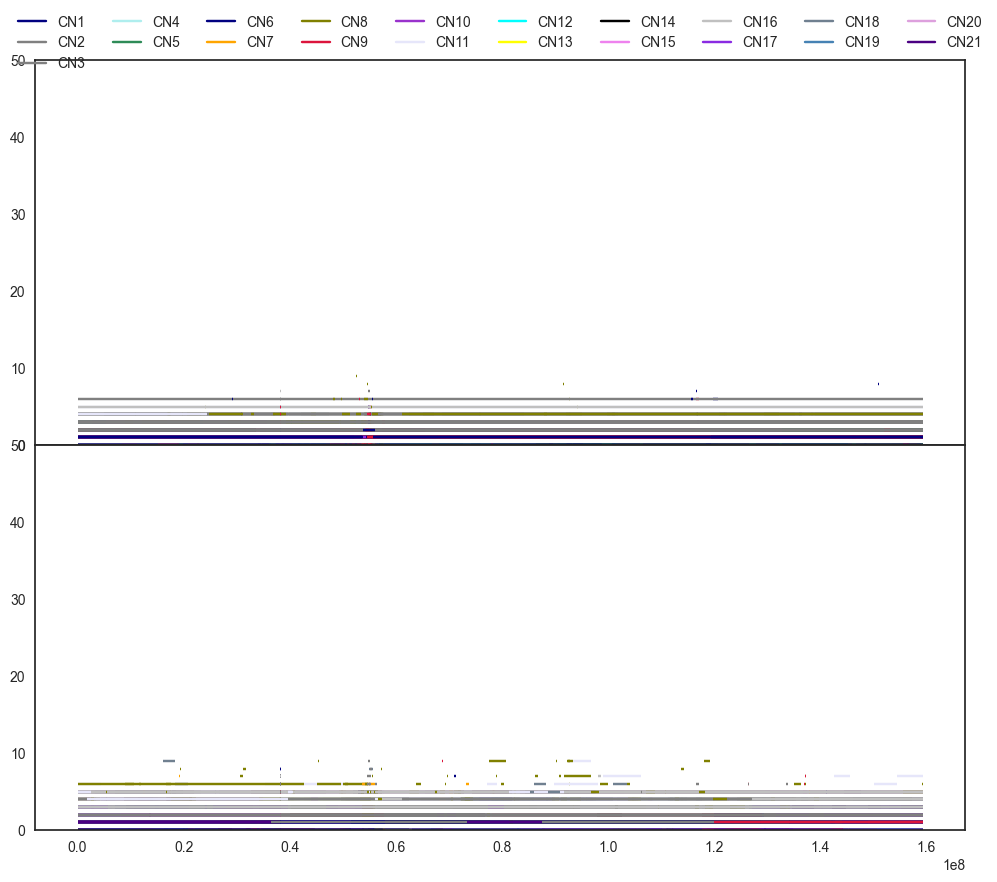

In [284]:
plot_cnv(cnv_sig, 'chr7', 'GBM')

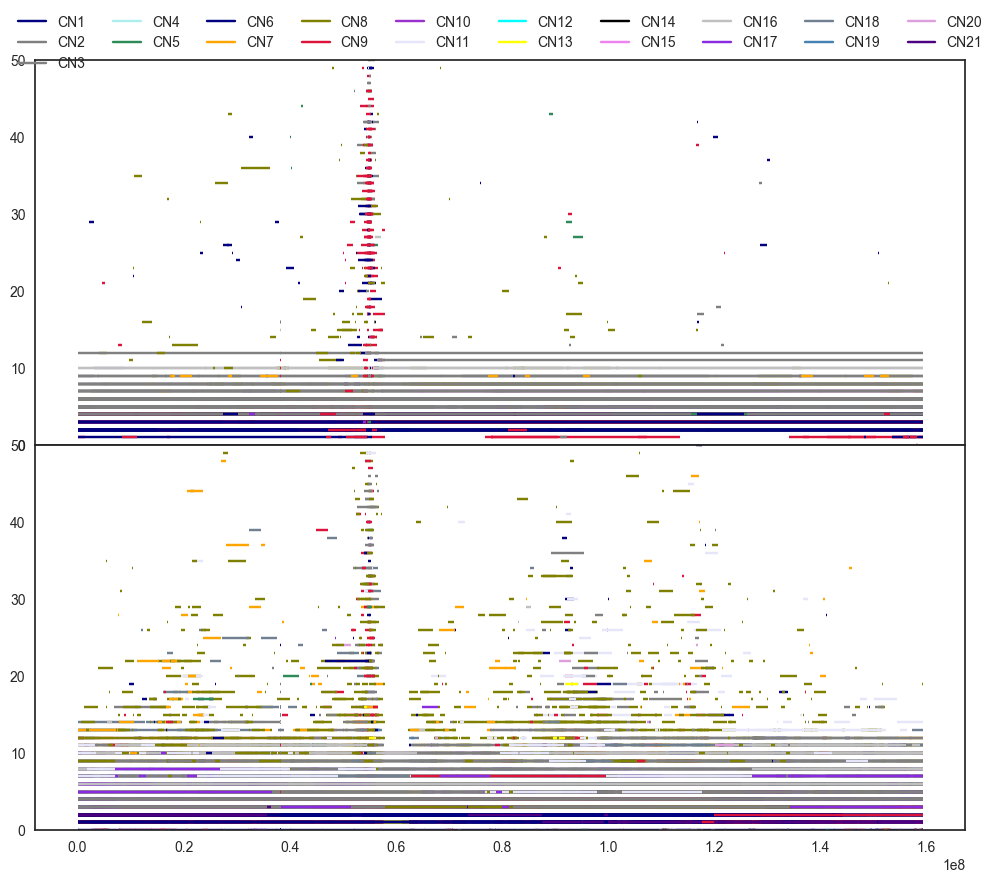

In [273]:
plot_cnv(cnv_sig, 'chr7', 'GBM')

In [ ]:
plot_cnv(cnv_sig, 'chr8', 'THCA')

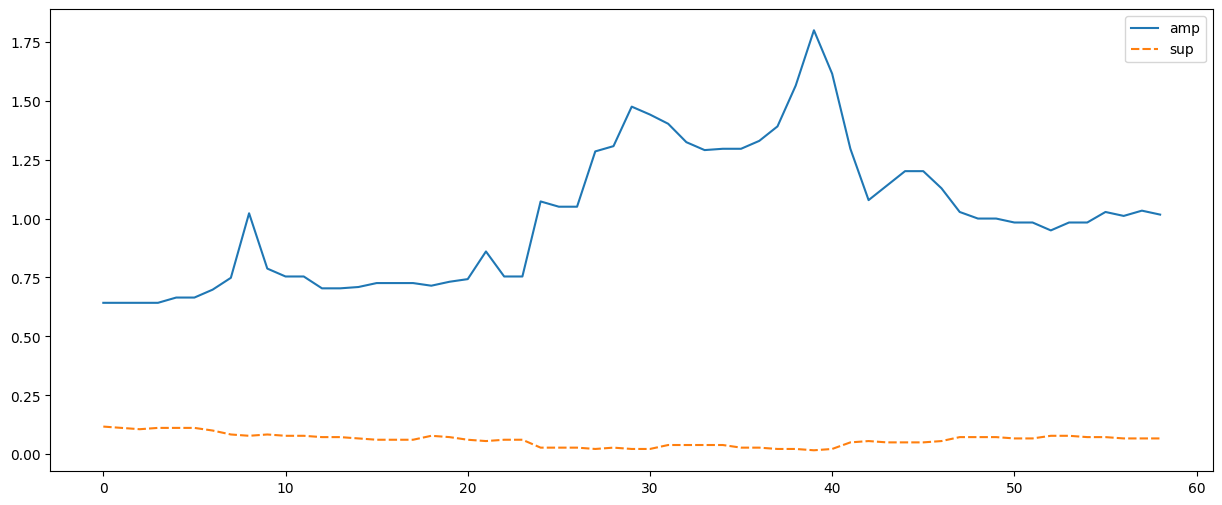

<Axes: >

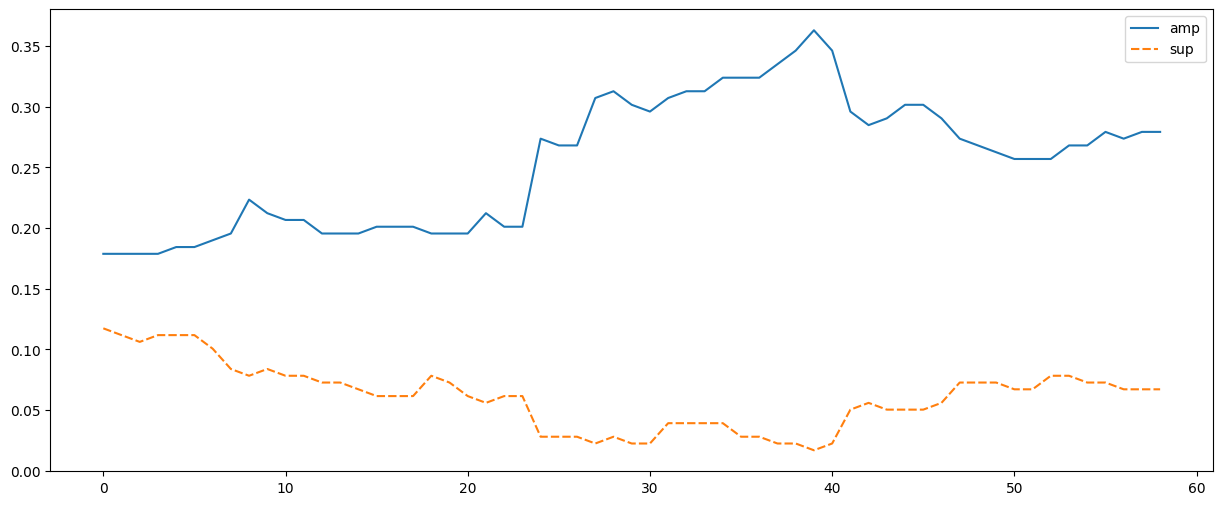

In [295]:
ct = 'PAAD'
chr='chr19'
f = ind.chr.get_layer('CNVAR', groups={'Cancertype':ct}, chr=chr)
d = f['Cancertype'][ct]['data']
amp = d.copy()
amp[amp<=2] = 0
sup = d.copy()
sup[sup>=2] = 0
norm = d.copy()
norm[norm!=2] = 0
plt.figure(figsize=(15, 6))
sns.lineplot(data=pd.DataFrame([np.multiply(np.divide(i.sum(0), (i>0).sum(0, keepdims=True)).flatten(),(i>0).sum(0)/d.shape[0]) for i in [amp, sup]], index=['amp', 'sup']).T)
plt.show()
f = ind.chr.get_layer('CNVAR', groups={'Cancertype':ct}, chr=chr)
d = f['Cancertype'][ct]['data']
amp = d.copy()
amp[amp<=2] = 0
sup = d.copy()
sup[sup>=2] = 0
norm = d.copy()
norm[norm!=2] = 0
plt.figure(figsize=(15, 6))
sns.lineplot(data=pd.DataFrame([(i>0).sum(0)/d.shape[0] for i in [amp, sup]], index=['amp', 'sup']).T)

/var/folders/dh/z5vdtxqd23qd9l10wsz4vjbw0000gp/T/ipykernel_6967/1582832774.py:12: RuntimeWarning: invalid value encountered in divide
  sns.lineplot(data=pd.DataFrame([np.multiply(np.divide(i.sum(0), (i>0).sum(0, keepdims=True)).flatten(),(i>0).sum(0)/d.shape[0]) for i in [amp, sup]], index=['amp', 'sup']).T)


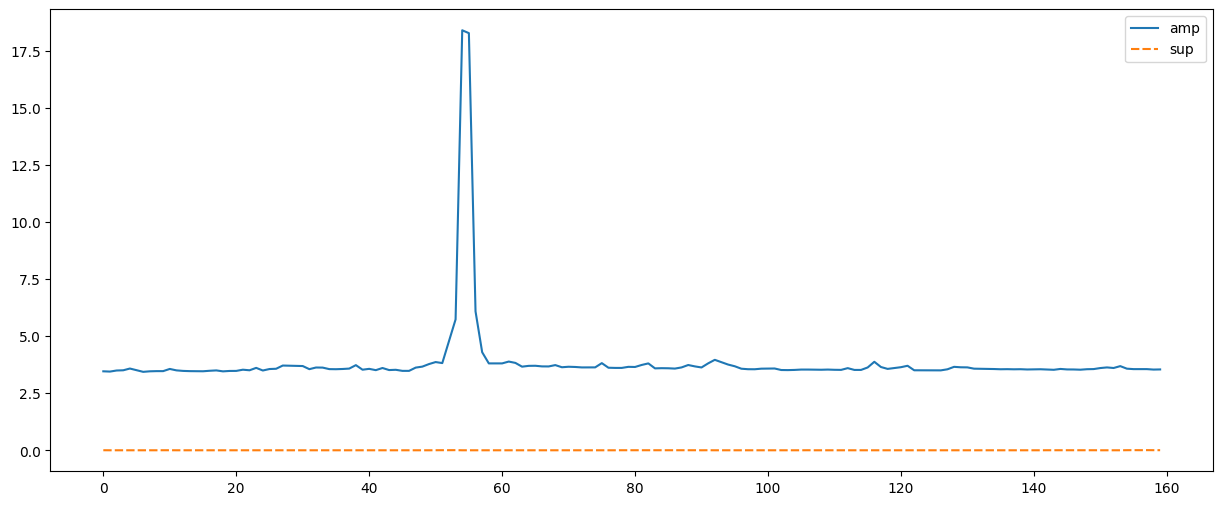

<Axes: >

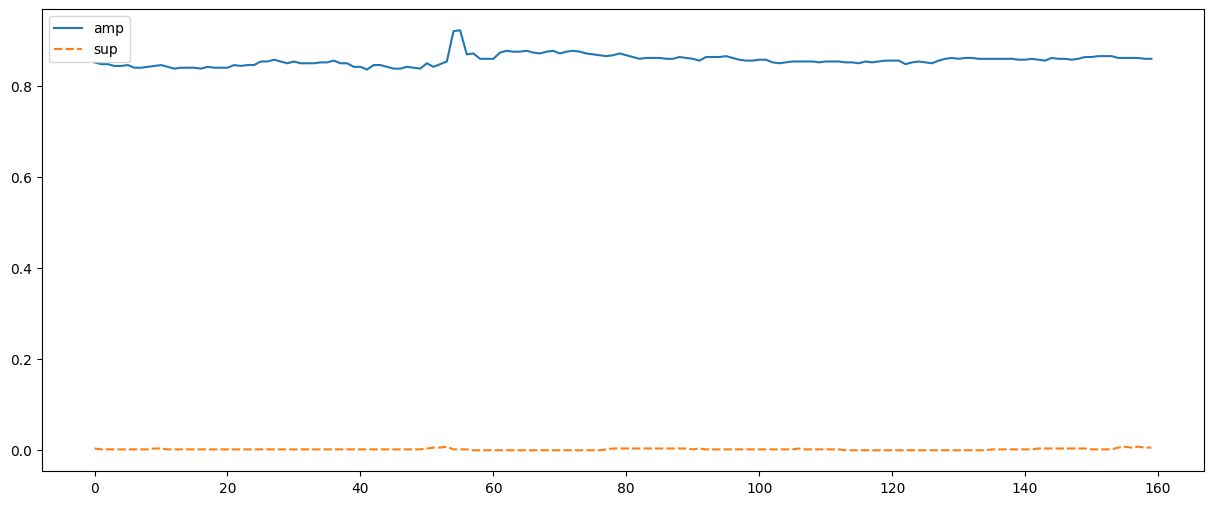

In [296]:
ct = 'GBM'
chr='chr7'
f = ind.chr.get_layer('CNVAR', groups={'Cancertype':ct}, chr=chr)
d = f['Cancertype'][ct]['data']
amp = d.copy()
amp[amp<=2] = 0
sup = d.copy()
sup[sup>=2] = 0
norm = d.copy()
norm[norm!=2] = 0
plt.figure(figsize=(15, 6))
sns.lineplot(data=pd.DataFrame([np.multiply(np.divide(i.sum(0), (i>0).sum(0, keepdims=True)).flatten(),(i>0).sum(0)/d.shape[0]) for i in [amp, sup]], index=['amp', 'sup']).T)
plt.show()
f = ind.chr.get_layer('CNVAR', groups={'Cancertype':ct}, chr=chr)
d = f['Cancertype'][ct]['data']
amp = d.copy()
amp[amp<=2] = 0
sup = d.copy()
sup[sup>=2] = 0
norm = d.copy()
norm[norm!=2] = 0
plt.figure(figsize=(15, 6))
sns.lineplot(data=pd.DataFrame([(i>0).sum(0)/d.shape[0] for i in [amp, sup]], index=['amp', 'sup']).T)

In [170]:
def plot_ridge_rows(data, index_col=None, subset_size=None):
    """
    Generate overlapping density plots (ridge plots) for each row in the dataframe.

    Parameters:
    - data: pandas DataFrame, where each row is considered as a distribution.
    - index_col: str or int, optional, column to be used as an index or identifier for each distribution.
    - subset_size: int, optional, number of rows to include in the plot for efficiency.
    """
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # If a subset is specified, randomly select a subset of rows
    if subset_size is not None and subset_size < len(data):
        data = data.sample(n=subset_size)

    # Transform the data into a long format
    if index_col is not None:
        melted_df = data.reset_index().melt(id_vars=[index_col], var_name='Variable', value_name='Value')
        labels = data[index_col].astype(str)
    else:
        melted_df = data.reset_index().melt(id_vars=['index'], var_name='Variable', value_name='Value')
        labels = melted_df['index'].astype(str)

    # Create the FacetGrid object
    num_distributions = len(labels.unique())
    pal = sns.cubehelix_palette(num_distributions, rot=-.25, light=.7)
    g = sns.FacetGrid(melted_df, row="index", hue="index", aspect=10, height=.4, palette=pal)

    # Draw the densities
    g.map(sns.kdeplot, "Value", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "Value", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Label the plot
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)
    g.map(label, "Value")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    return g

/Users/mossishahi/miniconda3/envs/shirin/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/mossishahi/miniconda3/envs/shirin/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/mossishahi/miniconda3/envs/shirin/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/mossishahi/miniconda3/envs/shirin/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all

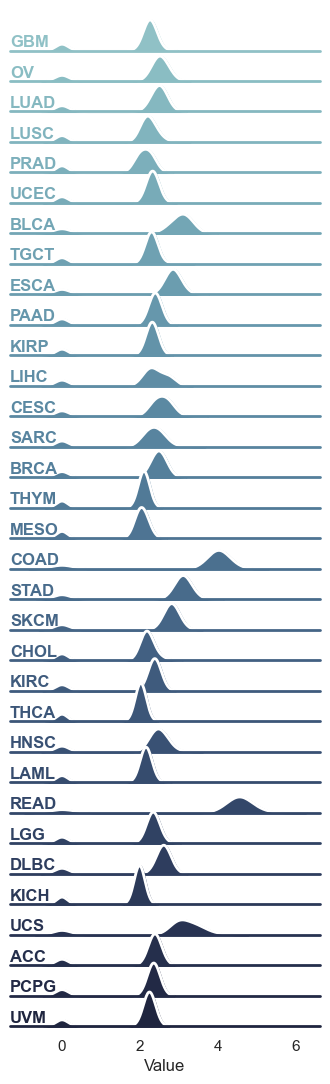

In [178]:
c = 'chr13'
cpan = ind.chr.get_layer('CNVAR', groups={'Cancertype':'all'}, chr=c)['Cancertype']
mean_cpan = np.vstack([v['data'].mean(0) for k, v in cpan.items()])
df = pd.DataFrame(mean_cpan, index=idx_cpand)
g = plot_ridge_rows(df)
g.savefig(f'facet_cnv_chr_{c}.png')

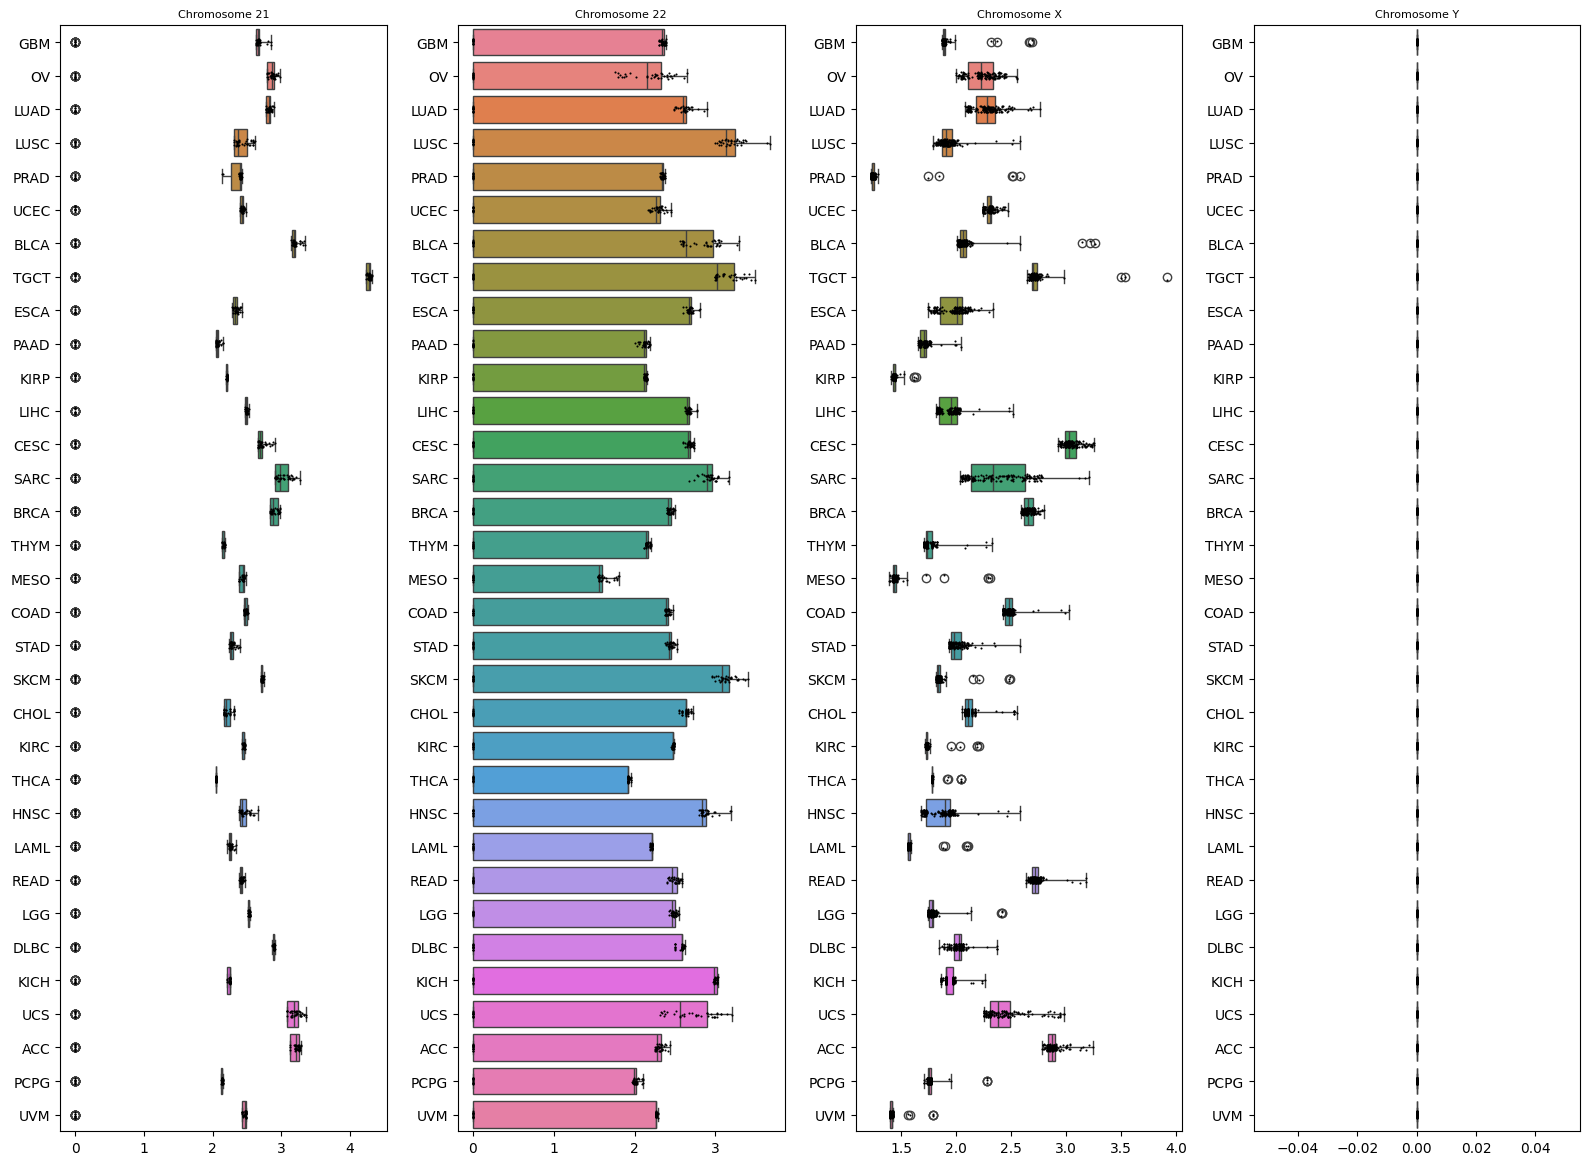

In [131]:
bunch=6
fig, axs = plt.subplots(1, 4, figsize=(16, 12))
for i, c in enumerate(ca.info.CHROMOSOMES['names'][4*(bunch):4*(bunch+1)]):
    axs = axs.flatten()
    cpan = ind.chr.get_layer('CNVAR', groups={'Cancertype':'all'}, chr=c)['Cancertype']
    mean_cpan = np.vstack([v['data'].mean(0) for k, v in cpan.items()])
    idx_cpand = [k for k, v in cpan.items()]
    df_mean_cpan = pd.DataFrame(mean_cpan, index=idx_cpand)
    sns.stripplot(df_mean_cpan.T, jitter=True, color='black', size=1.5,  orient='h', ax=axs[i%4])
    sns.boxplot(df_mean_cpan.T, orient='h', whis=10, ax=axs[i%4])
    axs[i].set_title(f'Chromosome {c.split('chr')[-1]}', fontsize=8)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    fig.savefig(f'cnv_box_chrs_b{bunch}.png')
# plt.suptitle('The distribution of Copy numbers across different chromosomes in sample from various cancer types', fontsize=20)
# plt.show()

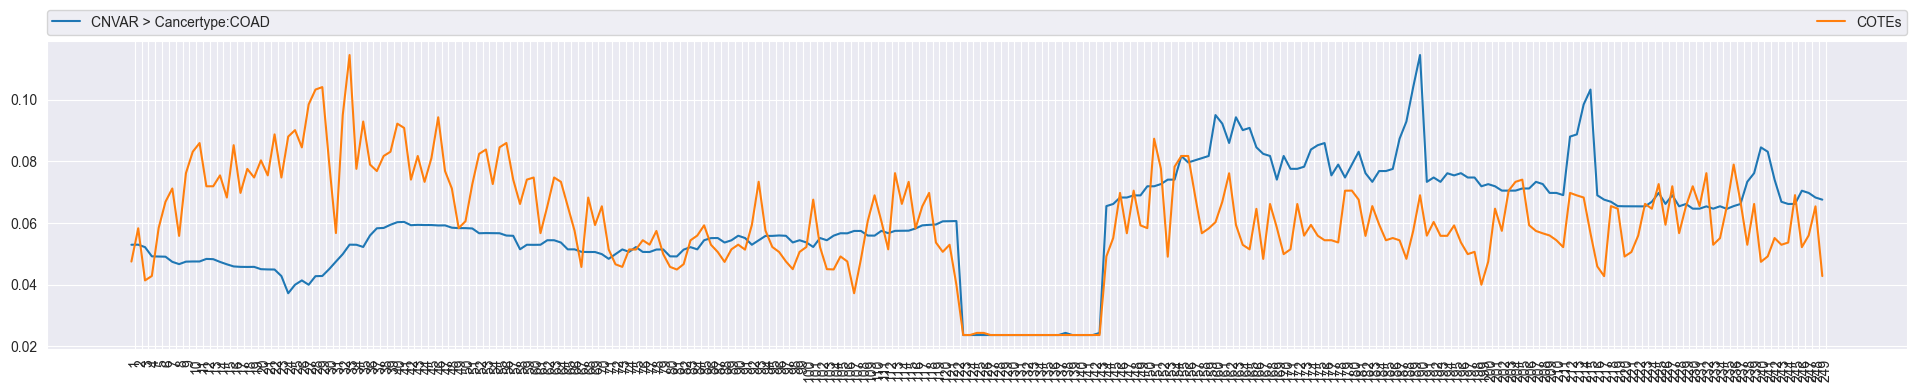

In [17]:
ca.pl.match_layers(ind.chr, ['CNVAR', 'COTEs'] , chr=1, aggregation='sum', normal_y=True, groups={'CNVAR':{'Cancertype':'COAD'}})

In [99]:
pca_transformed, group_assignments = ca.al.group_signals(x)

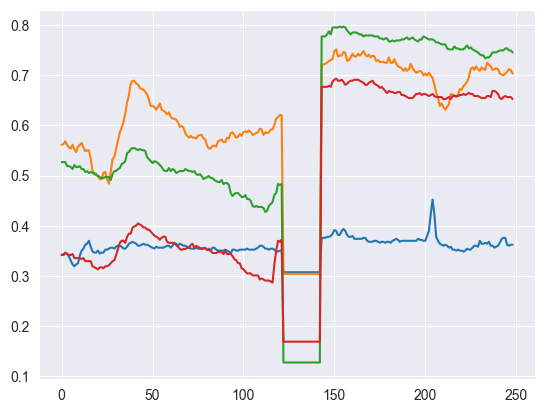

In [109]:
plt.plot(y)

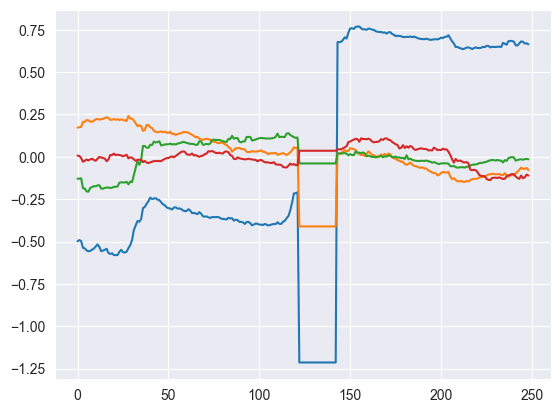

In [111]:
plt.plot(-1*pca_transformed)

<Axes: >

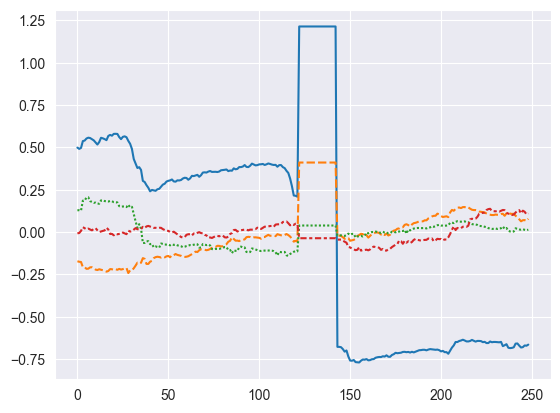

In [105]:
sns.lineplot(pd.DataFrame(pca_transformed), legend=False)

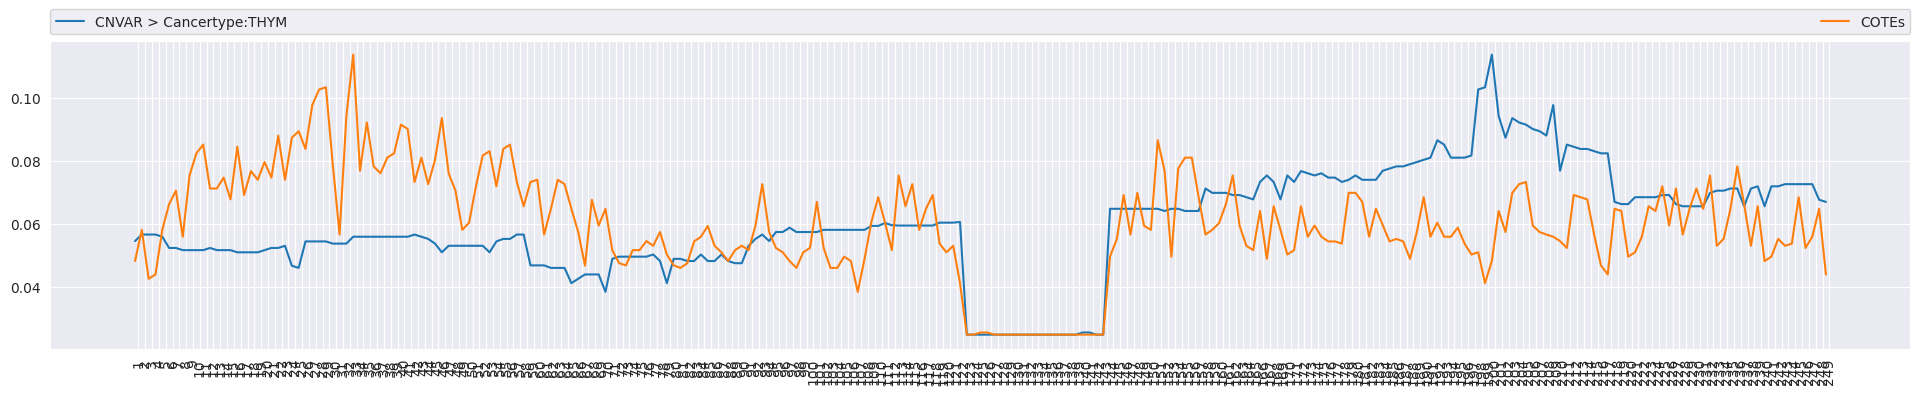

In [88]:
ca.pl.match_layers(ind.chr, ['CNVAR', 'COTEs'] , chr=1, aggregation='sum', normal_y=True, groups={'CNVAR':{'Cancertype':'THYM'}}, qnormalize=True)

In [ ]:
ca.pl.match_layers(ind.chr, ['CNVAR', 'COTEs'] , chr=1, aggregation='sum', normal_y=True, groups={'CNVAR':{'Cancertype':'BRCA'}})

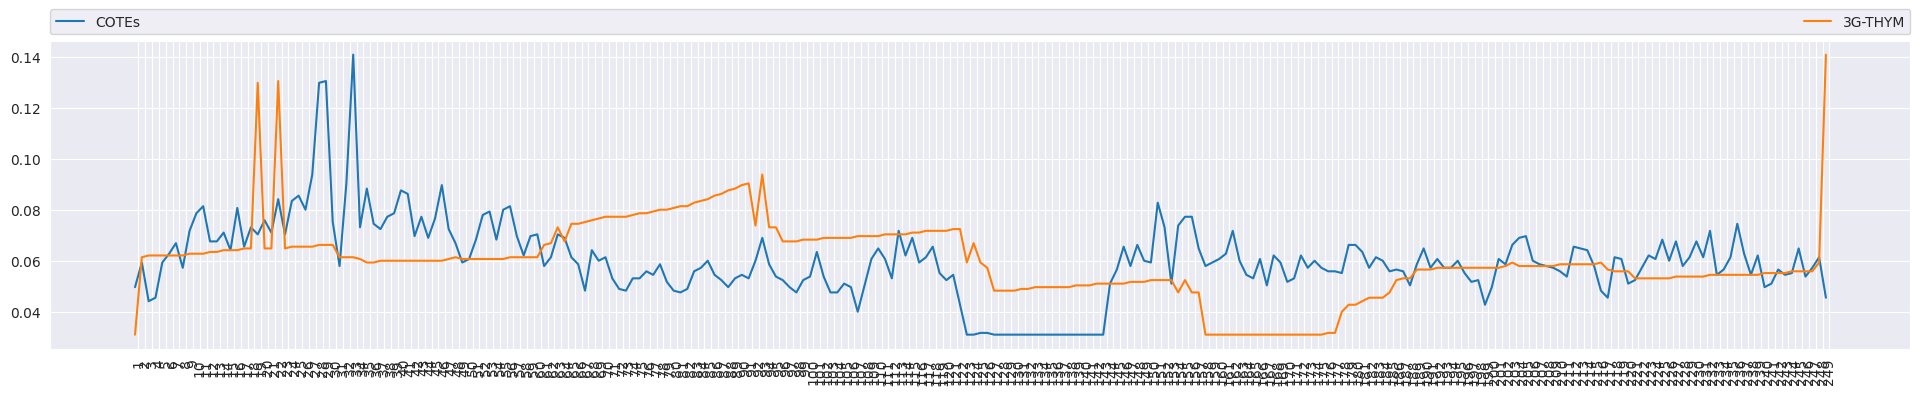

In [87]:
ca.pl.match_layers(ind.chr, ['COTEs', '3G-THYM'] , chr=1, aggregation='sum', normal_y=True, qnormalize=True)

In [15]:
x = np.vstack([cnv_gain(ind.chr.get_layer('CNVAR', chr='chr1', groups={'Cancertype':c})['Cancertype'][c]['data']).mean(0) for c in cnv_meta.cancer_type.unique()])
pca_transformed, group_assignments = ca.al.group_signals(x, method='pca')

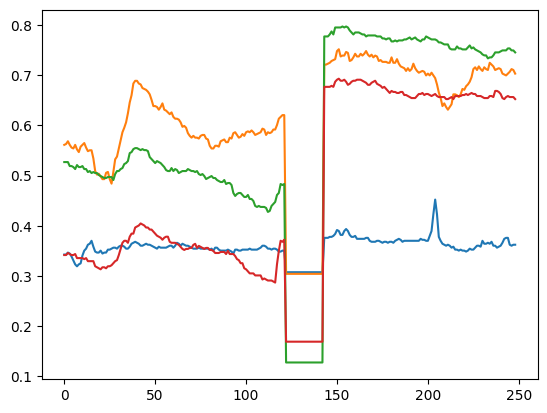

In [17]:
plt.plot(pca_transformed)

<Axes: >

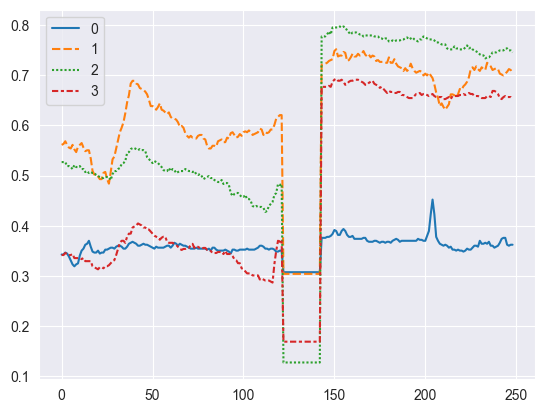

In [117]:
sns.lineplot(pd.DataFrame(pca_transformed))

<Axes: >

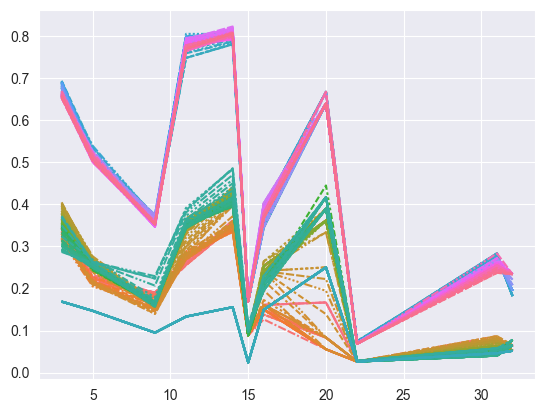

In [136]:
cmap = {1:'red', 2:'blue', 3:'orange', 0:'red'}
sns.lineplot(df.loc[[i==3 for i in group_assignments],:], legend=False)

<Axes: >

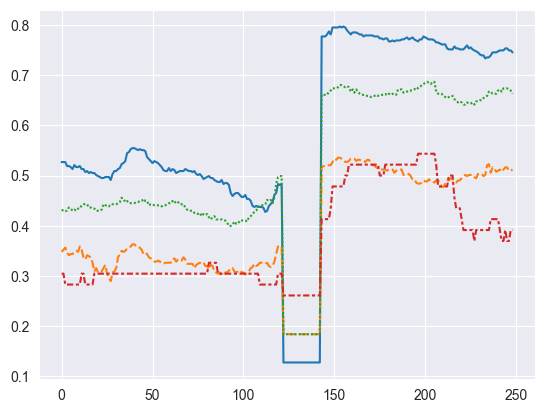

In [137]:
cmap = {1:'red', 2:'blue', 3:'orange', 0:'red'}
sns.lineplot(df.loc[[i==2 for i in group_assignments],:].T, legend=False)

In [19]:
df = pd.DataFrame(x)

In [21]:
df.to_csv('data.csv')

<Axes: >

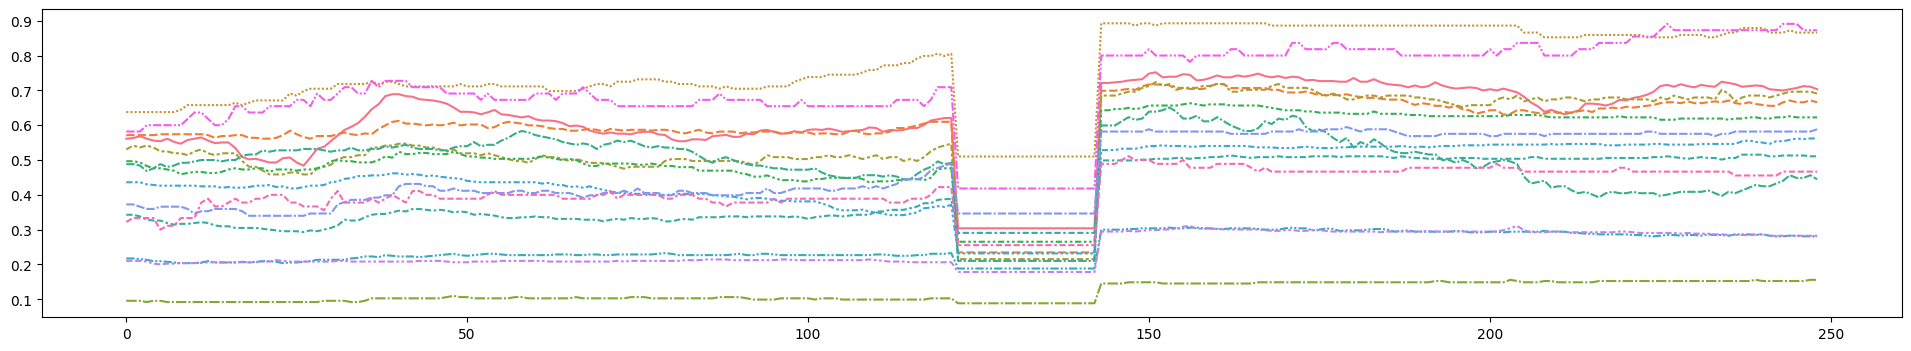

In [20]:
cmap = {1:'red', 2:'blue', 3:'orange', 0:'red'}
plt.figure(figsize=(24, 4))
sns.lineplot(df.loc[[i==1 for i in group_assignments],:].T, legend=False)

<Axes: >

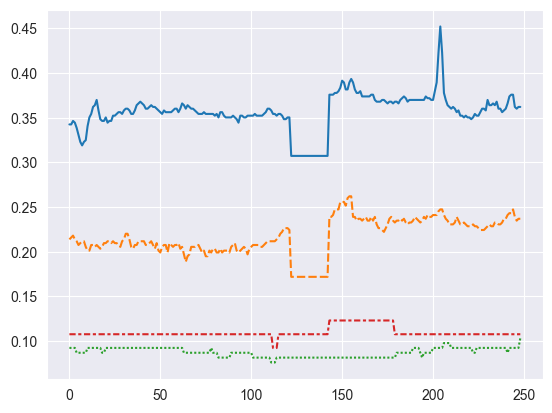

In [139]:
cmap = {1:'red', 2:'blue', 3:'orange', 0:'red'}
sns.lineplot(df.loc[[i==0 for i in group_assignments],:].T, legend=False)

In [118]:
df = pd.DataFrame(x)

<Axes: >

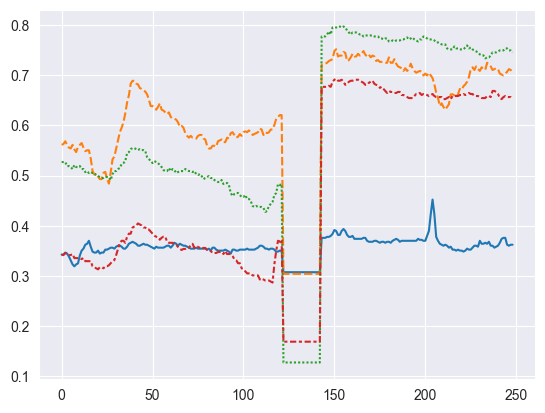

In [70]:
y = ca.tl.pca(np.transpose(x), 0.99)
# plt.legend()
sns.lineplot(pd.DataFrame(y), legend=False)

### Cancer driver Genes

In [3]:
cdriver = pd.read_csv('/cluster/home/t124771uhn/data/cancer_drivers/integrated_Unfiltered_drivers.tsv', sep='\t')

In [67]:
scores = {'cosine_sim':{i:[] for i in ca.info.CHROMOSOMES['names']}, 'spearman_correlation':{i:[] for i in ca.info.CHROMOSOMES['names']}, 'correlation_coefficient':{i:[] for i in ca.info.CHROMOSOMES['names']}}
pvalues = {'cosine_sim':{i:[] for i in ca.info.CHROMOSOMES['names']}, 'spearman_correlation':{i:[] for i in ca.info.CHROMOSOMES['names']}, 'correlation_coefficient':{i:[] for i in ca.info.CHROMOSOMES['names']}}
parent = "/cluster/home/t124771uhn/analysis/experiment5/subset/"
for chr in ca.info.CHROMOSOMES['names'][:-1]:
    for subset in os.listdir(parent):
        for m in scores.keys():
            score = pd.read_csv(f"/cluster/home/t124771uhn/analysis/experiment5/subset/{subset}/{chr}_{m}_score.csv", index_col=False)
            scores[m][chr].append(score)
            pval = pd.read_csv(f"/cluster/home/t124771uhn/analysis/experiment5/subset/{subset}/{chr}_{m}_pvalue.csv", index_col=False)
            pvalues[m][chr].append(pval)

In [98]:
tes_dir = '/cluster/home/t124771uhn/data/V2-TEs/non_olap'
cotes_dir = '/cluster/home/t124771uhn/data/V2-TEs/non_olap/cores1000/'
TEs = np.array([i.split('.')[0] for i in os.listdir(tes_dir) if i.endswith('.bed')])
COTES = np.array([i.split('.')[0] for i in os.listdir(cotes_dir) if i.endswith('.bed')])
te_meta = pd.read_csv('/cluster/home/t124771uhn/analysis/repeat_metadata.onlyTEs_full.txt', sep='\t')
te_df = te_meta.iloc[np.concatenate([np.where(te_meta['repname_numbered'].apply(lambda x: i.split('_')[0]==x.split('_')[0]))[0] for i in TEs]), :].loc[:, ['repname', 'Superfamily', 'repname_numbered']].copy()
te_df.index = range(1, len(te_df)+1)
te_df['COTE'] = te_df['repname_numbered'].apply(lambda x: x.split('_')[0] in np.array([i.split('_')[0] for i in np.intersect1d(TEs, COTES)]))
te_df.loc[971] = ['ERV3-16A3_I-int', 'ERVL', '369_ERV3-16A3_I-int', True]

In [143]:
def metric_visualization(d, chr='chr8'):
    df = pd.concat(d[chr])
    df = df.set_index('Unnamed: 0')
    _df = df.loc[pd.Series(df.index).apply(lambda x: x.split('>')[-1] in te_df[te_df.Superfamily=='LINE1']['repname_numbered'].values).values, :].dropna()
    sns.clustermap(_df, figsize=(24, 24), annot=True)
    return _df

/cluster/home/t124771uhn/miniconda3/envs/shirin/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cluster/home/t124771uhn/miniconda3/envs/shirin/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cluster/home/t124771uhn/miniconda3/envs/shirin/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cluster/home/t124771uhn/miniconda3/envs/shirin/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

<AxesSubplot: >

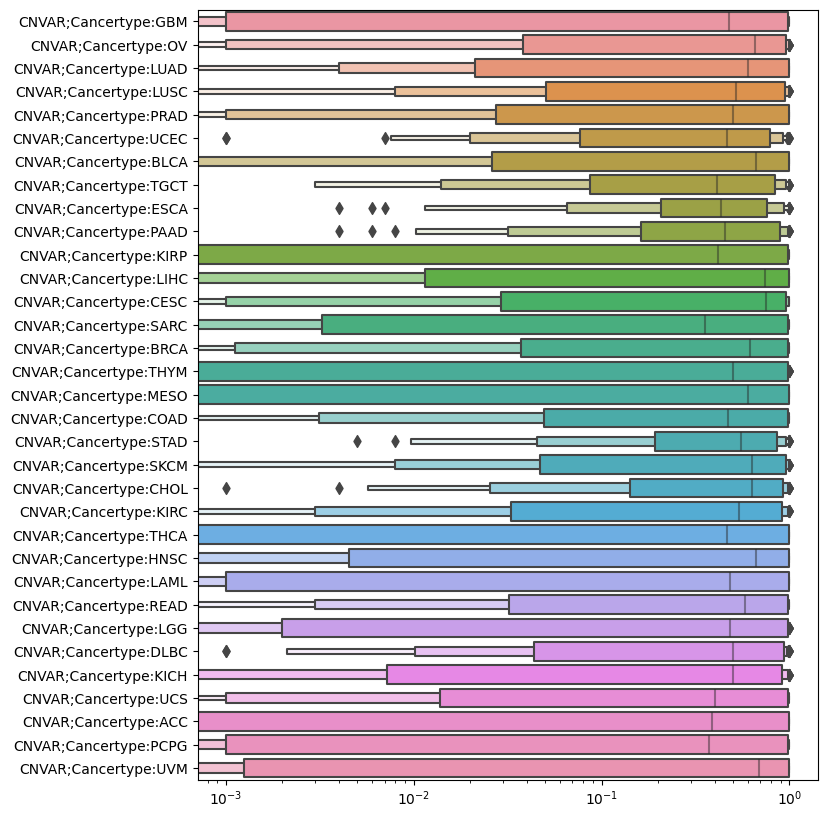

In [172]:
plt.figure(figsize=(8, 10))
plt.xscale('log')
sns.boxenplot(df, orient='h', dodge=True)

In [35]:
chr1_scores = pd.concat(scores['cosine_sim']['chr1']).dropna()
chr1_scores = chr1_scores.set_index('Unnamed: 0')

/cluster/home/t124771uhn/miniconda3/envs/shirin/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/cluster/home/t124771uhn/miniconda3/envs/shirin/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


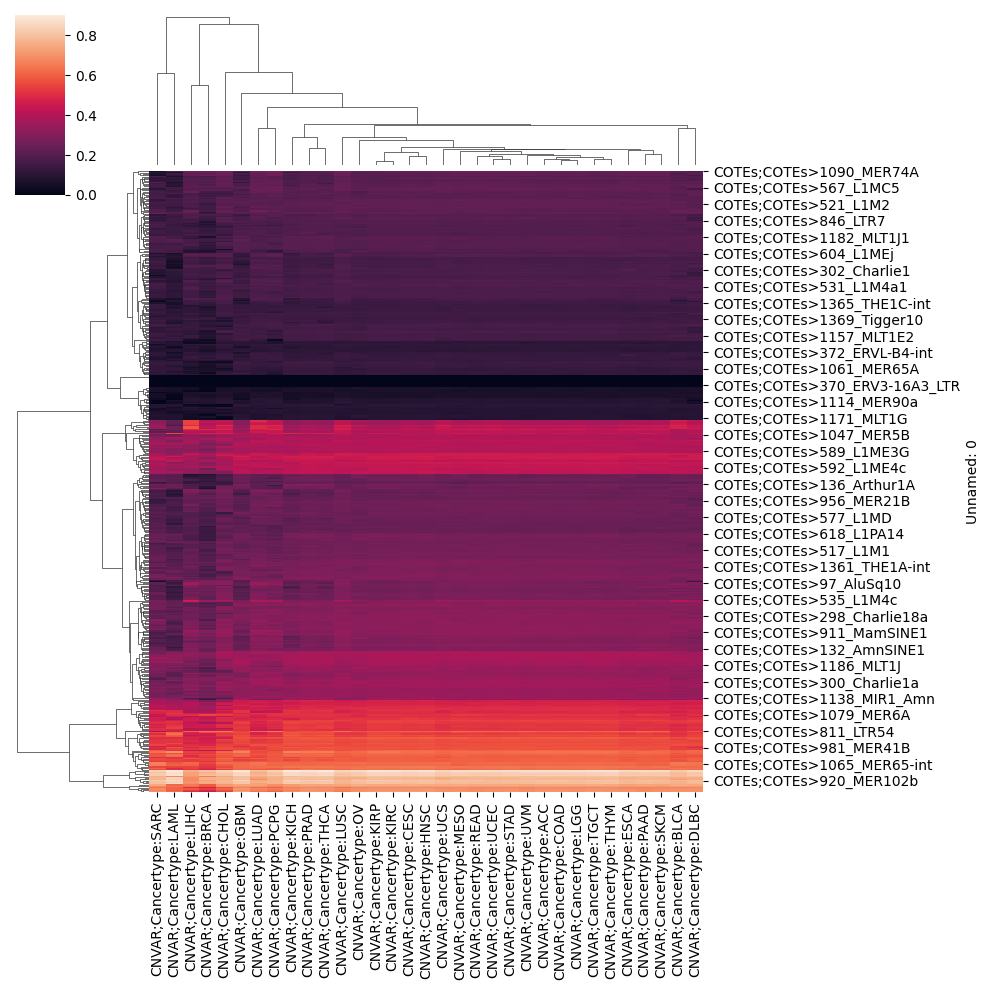

In [37]:
cl1 = sns.clustermap(ch1_scores)

In [39]:
row_order = cl1.dendrogram_row.reordered_ind
col_order = cl1.dendrogram_col.reordered_ind

In [40]:
chr1_scores = chr1_scores.iloc[row_order, col_order]

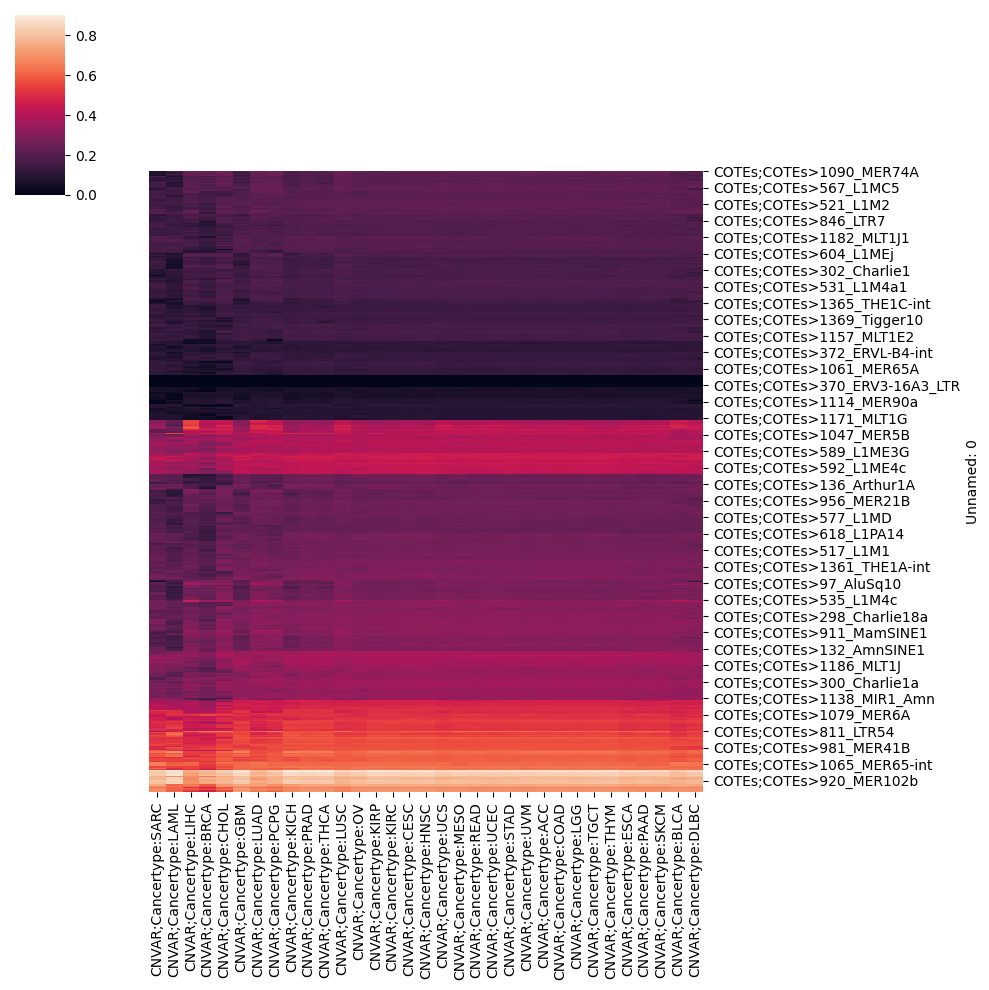

In [42]:
cl1 = sns.clustermap(chr1_scores, row_cluster=False, col_cluster=False)

/cluster/home/t124771uhn/miniconda3/envs/shirin/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/cluster/home/t124771uhn/miniconda3/envs/shirin/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


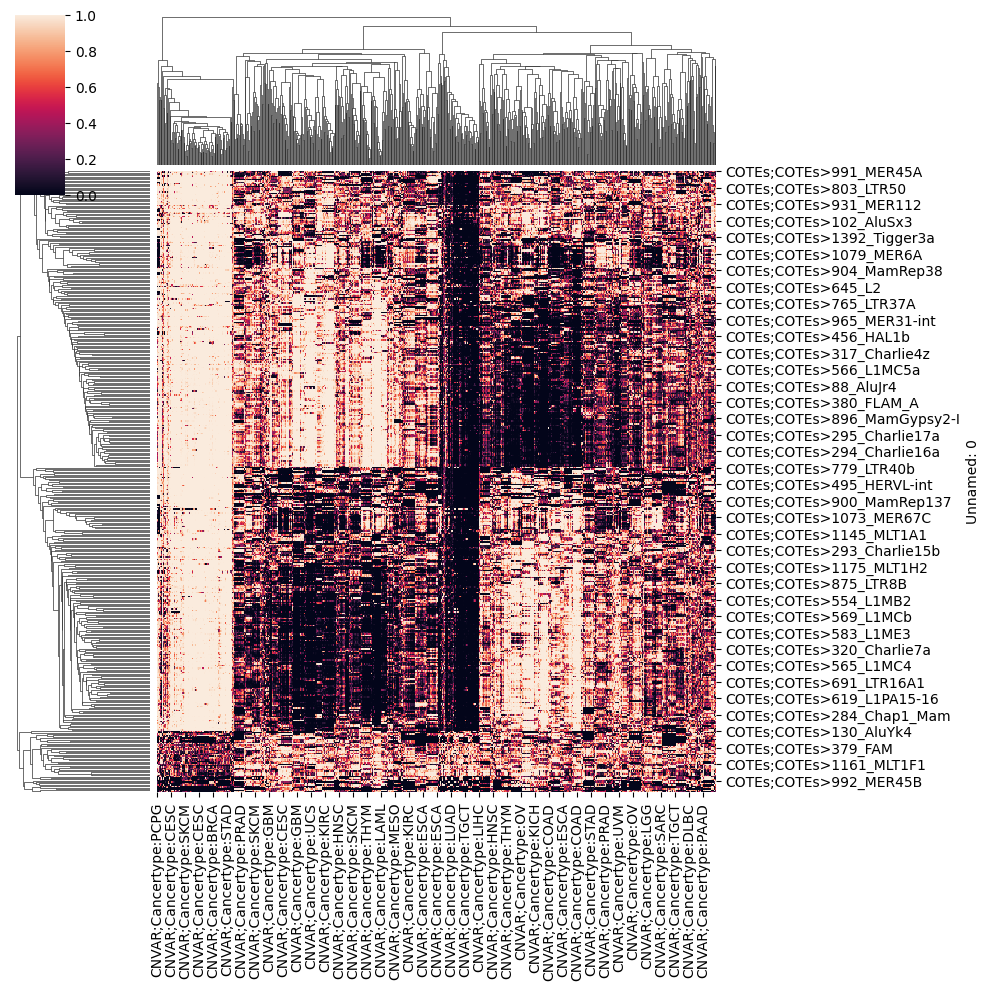

In [361]:
sns.clustermap(l2)

/cluster/home/t124771uhn/miniconda3/envs/shirin/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/cluster/home/t124771uhn/miniconda3/envs/shirin/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


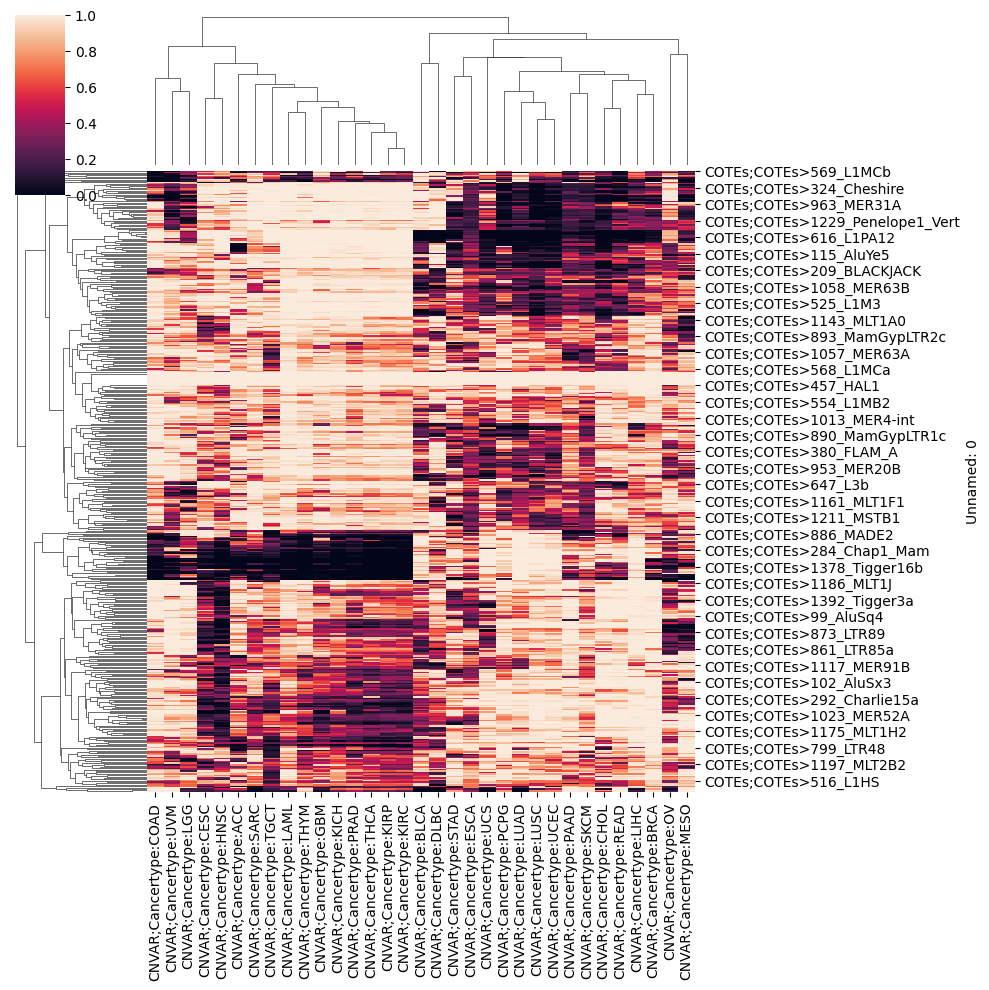

In [234]:
sns.clustermap(chr1_pvals)